### Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
from pathlib import Path
from IPython.display import display

### Choose the group(s) to analyse
Possible groups:
- test
- control
- all

    

In [10]:
group = "control"  
#group = "test"
#group = "all" 

### Define a function to add a numeric label to the eye movement types
Possible labels:
- Unclassified -> 0
- Saccade -> 1
- Fixation -> 2


In [3]:
def event_label (row):
   if row['Eye movement type'] == 'Unclassified' :
      return 1
   if row['Eye movement type'] == 'Saccade' :
      return 2
   if row['Eye movement type'] == 'Fixation' :
      return 3
   return 1

### Define function to use left or right pupil diameter as mean if only one present
#### not in use currently

In [4]:
def fix_left_based_on_right(left, right):
    if np.isnan(left) and ~np.isnan(right): return right
    return left

In [5]:
def fix_right_based_on_left(left, right):
    if np.isnan(right) and ~np.isnan(left): return left
    return right

### Read and clean the data
#### For each participant:
- count nummber of attempts
- filter away those with more or less than 8 attemps
- remove empty columns
- replace EyesNotFound with Unclassified
- add numeric label for eye event type
- change pupil diameter data type to float
- add mean for pupil diameter

In [11]:
all_participants= []

# Define folder based on the group variable
folder_path = "Data/" + group #Possible groups: control, test, all. Set on the top of the notebook

#Do for each file in the folder
for filename in os.listdir(folder_path):

    file_path = os.path.join(folder_path, filename) 
    df_file_content = pd.read_csv(file_path,"\t", na_values='.', low_memory=False) #Read participant-file to a dataframe
    df = df_file_content

    number_of_attemps = df_file_content["Recording start time UTC"].nunique()
    # Take only participants with 8 attempts - there were 8 tasks in the experience
    if number_of_attemps == 4:
        # Remove empty columns
        # nan_value = float("NaN") #Define NaN value
        # df_file_content.replace("", nan_value, inplace=True) #Replace all the empty fileds with NaN
        df_file_content.dropna(how = 'all', axis=1, inplace=True) #Remove columns with NaNs only (drop columns where all rows = NaN)

        # Replace all "EyesNotFound" to "Unclassified"
        df_file_content = df_file_content.replace("EyesNotFound", "Unclassified")
        df_file_content['Eye movement type'].fillna("Unclassified", inplace=True)

        # Add column with numeric label for the eye movement type
        df_file_content['Label'] = df_file_content.apply(lambda row: event_label(row), axis=1)

        #Copy the needed columns   
        df_result = df_file_content[["Participant name", "Recording timestamp", "Eye movement type", "Event", "Pupil diameter left", "Pupil diameter right", "Label"]]
        
        #Change the data type of pupil diamater to float
        df_result["Pupil diameter left"] = df_result["Pupil diameter left"].str.replace(',', '.').astype(float)
        df_result["Pupil diameter right"] = df_result["Pupil diameter right"].str.replace(',', '.').astype(float)
   
        df_result["Pupil diameter left fixed"] = df_result.apply(lambda x: fix_left_based_on_right(x['Pupil diameter left'], x['Pupil diameter right']), axis = 1 )
        df_result["Pupil diameter right fixed"] = df_result.apply(lambda x: fix_right_based_on_left(x['Pupil diameter left'], x['Pupil diameter right']), axis = 1 )
        
        #Fill up missing values by interpolation
        # df_result = df_cleaned[["Gaze point Y", "Gaze point X", "Pupil diameter left", "Pupil diameter right"]].interpolate(method='nearest').ffill().bfill()
        # df_result["Pupil diameter left"] = df_result["Pupil diameter left"].str.replace(',', '.').astype(float)
        # df_result["Pupil diameter right"] = df_result["Pupil diameter right"].str.replace(',', '.').astype(float)

        #Calculate the average from the both pupils (only those with both pupil measurements will get the value)
        # df_result["Pupil_diameter_mean"] =  df_result.apply(lambda x: add_pupil_mean_based_on_lef_or_right(x['Pupil diameter left'], x['Pupil diameter right']), axis = 1 )
        df_result["Pupil_diameter_mean"] = (df_result['Pupil diameter left'] + df_result['Pupil diameter right'])/2
        df_result["Pupil_diameter_D"] = abs((df_result["Pupil diameter left"] - df_result["Pupil diameter right"]))
        df_result["Pupil_diameter_p"] = df_result["Pupil_diameter_D"]/df_result["Pupil_diameter_mean"]
       
        #Calculate the average from the both pupils (only those with both pupil measurements will get the value) -> with fixed pupil diameters
        df_result["Pupil_diameter_mean_fixed"] =   (df_result['Pupil diameter left fixed'] + df_result['Pupil diameter right fixed'])/2
        df_result["Pupil_diameter_D_fixed"] = abs((df_result["Pupil diameter left fixed"] - df_result["Pupil diameter right fixed"]))
        df_result["Pupil_diameter_p_fixed"] = df_result["Pupil_diameter_D_fixed"]/df_result["Pupil_diameter_mean_fixed"]
       
        # Add to the list with all the participants
        all_participants.append(df_result)

Participant0002.tsv
5
Participant0004.tsv
9
Participant0006.tsv
13
Participant0008.tsv
17
Participant0032.tsv
3


### Read the empathy scores before and after

In [9]:
columns_A = ['Participant nr','Total Score original','Total Score extended']
columns_B = ['Participant nr','SUM STANDARD','Sum']

empathy_before = pd.read_csv(os.path.join('empathy_scores', 'Questionnaire_datasetIA.csv'), usecols=columns_A, dtype={'Participant nr' : str})
empathy_before = empathy_before.dropna(how='all')
empathy_after = pd.read_csv(os.path.join('empathy_scores', 'Questionnaire_datasetIB.csv'),  usecols=columns_B, dtype={'Participant nr' : str}, delimiter=';')
#display(empathy_before)
#display(empathy_after)

### Define function to divide each participant file into one time series per attempt
<p> Only participants with 8 attempts are taken further</p>
<p> Each participant wil have a list of 8 time series</p>

In [10]:
# def get_list_of_time_series_for_participant(all_participants):

#     #print(all_participants)
#     start = "ImageStimulusStart"
#     stop = "ImageStimulusEnd"
#     options = [start, stop]
#     participant_time_series_list = []

#     for participant_df in all_participants:

#         participant_number = participant_df['Participant name'].iloc[0].replace("Participant00", "")
#         df_start_stop = participant_df.loc[participant_df['Event'].isin(options)]
#         df_attempts = df_start_stop[['Recording timestamp','Event']]
#         df_attempts.reset_index(drop=True, inplace=True)

#         participant_attempts = []

#         for i in range(0,len(df_attempts),2):
#             from_ts = df_attempts.iloc[i]['Recording timestamp']
#             #print(from_ts)
#             to_ts = df_attempts.iloc[i+1]['Recording timestamp']
#             #print(to_ts)
            
#             timeseries_df = participant_df[participant_df['Recording timestamp'].between(from_ts, to_ts, inclusive='neither')]
#             timeseries_df['Index'] = range(1, len(timeseries_df) + 1)
#             #get average diameter of the attempt and add
#             time_serias_mean = timeseries_df['Pupil_diameter_mean_fixed'].mean()
#             participant_attempts.append((timeseries_df,time_serias_mean ))
            
#         participant_time_series_list.append((participant_number, participant_attempts))

    
#     return participant_time_series_list

    

#### Define as dictionary

In [11]:
def get_list_of_time_series_for_participant_df(all_participants):

    #print(all_participants)
    start = "ImageStimulusStart"
    stop = "ImageStimulusEnd"
    options = [start, stop]
    participant_time_series_list = []

    for participant_df in all_participants:

        participant_number = participant_df['Participant name'].iloc[0].replace("Participant00", "")
        df_start_stop = participant_df.loc[participant_df['Event'].isin(options)]
        df_attempts = df_start_stop[['Recording timestamp','Event']]
        df_attempts.reset_index(drop=True, inplace=True)

        participant_attempts = []

        for i in range(0,len(df_attempts),2):
            from_ts = df_attempts.iloc[i]['Recording timestamp']
            #print(from_ts)
            to_ts = df_attempts.iloc[i+1]['Recording timestamp']
            #print(to_ts)
            
            timeseries_df = participant_df[participant_df['Recording timestamp'].between(from_ts, to_ts, inclusive='neither')]
            timeseries_df['Index'] = range(1, len(timeseries_df) + 1)
            #get average diameter of the attempt and add
            time_serias_mean = timeseries_df['Pupil_diameter_mean_fixed'].mean()
            time_series_std = timeseries_df['Pupil_diameter_mean_fixed'].std()
            new_record_df = {"ts_df":timeseries_df, "ts_mean":time_serias_mean, "ts_std":time_series_std}
            participant_attempts.append(new_record_df)
        
        new_record_participant = {"number" : str(int(float(participant_number))), "attempts": participant_attempts}
        participant_time_series_list.append(new_record_participant)

    
    return participant_time_series_list

### Create a list of 8 time series for each participant (one time series per attempt)

In [12]:
#all_participants_with_all_time_series = get_list_of_time_series_for_participant(all_participants)
all_participants_with_all_time_series_dict = get_list_of_time_series_for_participant_df(all_participants)

### Add empathy score before and after for each participant

In [13]:
def add_empathy_scores_for_all_participants(all_participants):

    for participant in all_participants:
        #print(participant['number'])
        participant['empathy_before_std'] = empathy_before['Total Score original'].loc[empathy_before['Participant nr'] == participant['number']].iloc[0]
        participant['empathy_before_ext'] = empathy_before['Total Score extended'].loc[empathy_before['Participant nr'] == participant['number']].iloc[0]
        participant['empathy_after_std'] = empathy_after['SUM STANDARD'].loc[empathy_after['Participant nr'] == participant['number']].iloc[0]
        participant['empathy_after_ext'] = empathy_after['Sum'].loc[empathy_after['Participant nr'] == participant['number']].iloc[0]
        #print(participant['empathy_after_ext'])
    

### Add empaty scores to the all participant list

In [14]:
add_empathy_scores_for_all_participants(all_participants_with_all_time_series_dict)
print("Number of participants:")
print(len(all_participants_with_all_time_series_dict))

print(all_participants_with_all_time_series_dict[0]['attempts'][0]['ts_df'])

Number of participants:
24
      Participant name  Recording timestamp Eye movement type  \
3082   Participant0001             23419315          Fixation   
3083   Participant0001             23419315          Fixation   
3084   Participant0001             23426120          Fixation   
3085   Participant0001             23434449          Fixation   
3086   Participant0001             23442782          Fixation   
...                ...                  ...               ...   
82495  Participant0001             43384336      Unclassified   
82496  Participant0001             43393702      Unclassified   
82497  Participant0001             43393702      Unclassified   
82498  Participant0001             43432292      Unclassified   
82499  Participant0001             43548361      Unclassified   

                             Event  Pupil diameter left  Pupil diameter right  \
3082   Eye tracker Calibration end                  NaN                   NaN   
3083            ImageStimulusS

### Take a sample an check how the data looks like

##### The model:

```
[ // 0-23 index
    {
        "number": string, //participant number
        "attempts" : [ // 0-7 index
            {
                "ts_df" : DataFrame[], //list of 8 dataframes with time series, one for each attempt 
                "ts_mean" : float // mean of eye pupil in the attempt 
                "std_dev" : float // standard deviation for eye pupil in the attempt
            }
        ],
        "empathy_before_std" : float,
        "empathy_after_std" : float,
        "empathy_before_ext" : float,
        "empathy_after_ext" : float
    }
]
```

#### ts_df columns (8 time series for each participant): 
- Participant name  
- Recording timestamp 
- Eye movement type 
- Event  
- Pupil diameter left  
- Pupil diameter right 
- Label  
- Pupil diameter left fixed  
- Pupil diameter right fixed  
- Pupil_diameter_mean  
- Pupil_diameter_D  
- Pupil_diameter_p  
- Pupil_diameter_p_fixed  
- Pupil_diameter_D_fixed  
- Pupil_diameter_mean_fixed
- Index  


### Check the data for one participant

In [15]:
d_2 = all_participants_with_all_time_series_dict[0]["number"]
d_4 = all_participants_with_all_time_series_dict[0]["attempts"][0]["ts_df"]
d_5 = all_participants_with_all_time_series_dict[0]["attempts"][0]["ts_mean"]
d_6 = all_participants_with_all_time_series_dict[0]["empathy_after_ext"]
print(d_5)
print(all_participants_with_all_time_series_dict[0]["empathy_after_ext"])

3.0175242687030805
137


### Define function to read consecutive eye movement events of the same type and count their total duration

In [16]:
def get_consecutive_events_duration_from_time_series(dataframe):

    prevoius_event_type = ""
    consecutive_events =  pd.DataFrame(columns =  ["Recording timestamp"])
    summary_consecutive_events = pd.DataFrame(columns =  ["Start timestamp", "Event type", "Duration", "Count"])
   
    for i in range(len(dataframe)):
        current_event_type = dataframe.iloc[i]["Eye movement type"] # Possible: Saccade, Fixation, Unclassified, EyesNotFound
        
        if i == 0: # First run - no previous event
            prevoius_event_type = current_event_type # Set for the first run in the loop

        if prevoius_event_type != current_event_type: # Start of a new event-sequence
            summary_consecutive_events = add_new_row(consecutive_events, dataframe, prevoius_event_type, summary_consecutive_events, i)
            prevoius_event_type = current_event_type
            consecutive_events = consecutive_events.iloc[0:0]
        
        if prevoius_event_type == current_event_type : # A enw event in the current event-sequence
            new_row = {'Recording timestamp': dataframe.iloc[i]["Recording timestamp"]}
            consecutive_events = consecutive_events.append(new_row, ignore_index=True)

        if i==len(dataframe):  # Last row: finish event-sequence
            summary_consecutive_events = add_new_row(consecutive_events, dataframe, prevoius_event_type, summary_consecutive_events, i)
    
    display(summary_consecutive_events)

def add_new_row(consecutive_events, dataframe, prevoius_event_type, summary_consecutive_events, i):
    event_count = consecutive_events.shape[0]
    consecutive_event_duration = dataframe.iloc[i]["Recording timestamp"]- consecutive_events["Recording timestamp"].iat[0]
    start_timestamp = consecutive_events["Recording timestamp"][0]
    new_row = {'Start timestamp':start_timestamp, 'Event type': prevoius_event_type, 'Duration':consecutive_event_duration, 'Count':event_count}
    summary_consecutive_events = summary_consecutive_events.append(new_row, ignore_index=True)

    return summary_consecutive_events



In [17]:
data = all_participants_with_all_time_series_dict[1]["attempts"][7]["ts_df"] #pd.read_csv("Data/testdata.csv", sep=";")
#get_consecutive_events_duration_from_time_series(data)

,Start timestamp,Event type,Duration,Count
0,4361731,Fixation,116688,14
1,4478419,Saccade,33330,4
2,4511749,Unclassified,458307,72
3,4970056,Saccade,49963,6
4,5020019,Unclassified,16688,2
...,...,...,...,...
4286,69362225,Saccade,33213,4
4287,69395438,Unclassified,8329,1
4288,69403767,Saccade,25039,3
4289,69428806,Unclassified,8332,1


### Plot each type as label in own diagram

<AxesSubplot:xlabel='Index'>

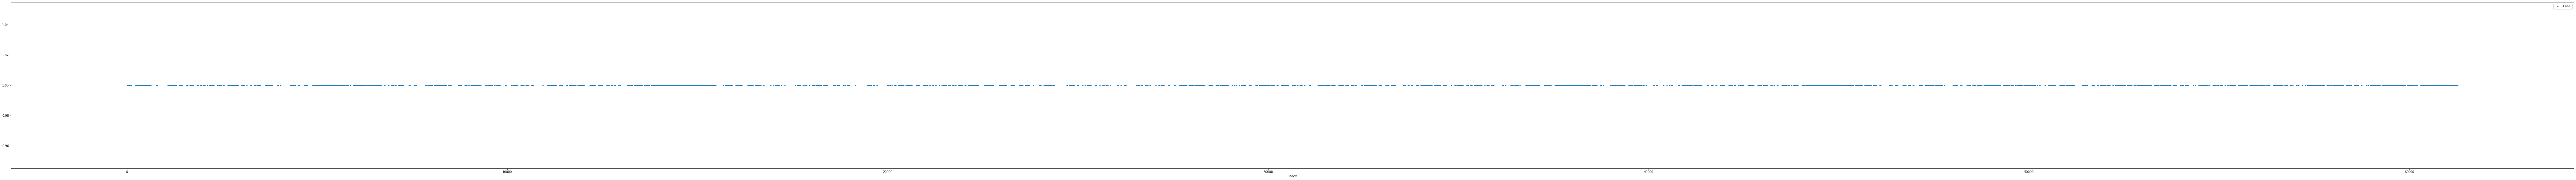

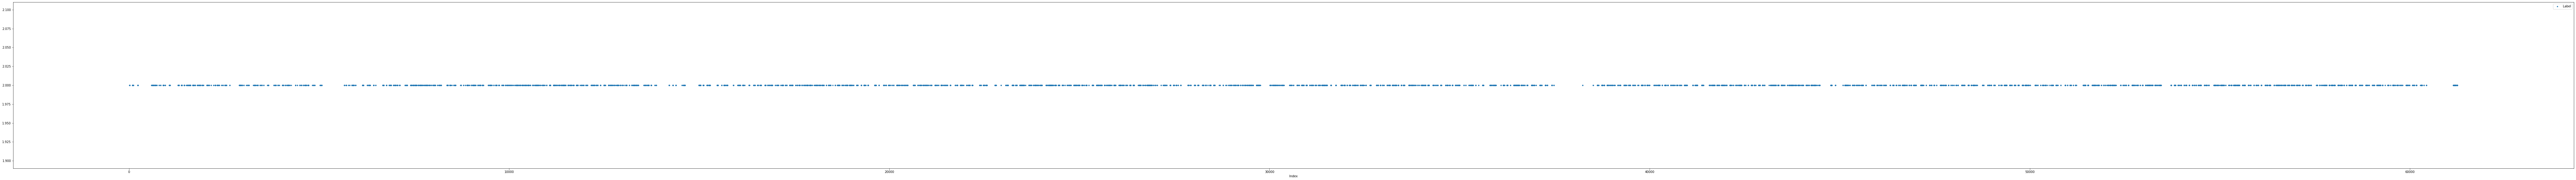

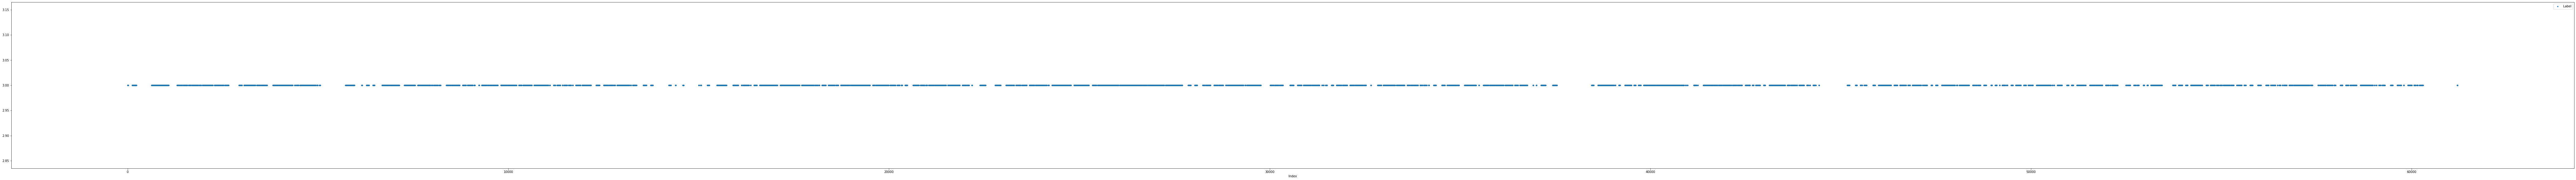

In [18]:
# just to test - for one participant
data = all_participants_with_all_time_series_dict[1]["attempts"][7]["ts_df"]
data1= data.copy()
data2= data.copy()
data3= data.copy()

#print(data.info())
nan_value = float("NaN") #Define NaN value
#data_unclassified = data.loc[data['Label'] == 1]
data1.loc[data1['Label']!=1,['Label']] = nan_value
#print(data1['Label'])

#display(data1)
data1.plot('Index', 'Label', style=".", figsize=(150,10))

data2.loc[data2['Label']!=2,['Label']] = nan_value
data2.plot('Index', 'Label', style=".", figsize=(150,10))

data3.loc[data3['Label']!=3,['Label']] = nan_value
data3.plot('Index', 'Label', style=".", figsize=(150,10))



### Code to create a file, returns filepath

In [19]:
def create_file(path, name):
    path_created = os.path.join(path, name)
    print(path_created)
    myfile = Path(path_created)
    myfile.touch(exist_ok=True)
    return path_created
    

### Display with matplotlib : eye movement type (label)

FIG A1

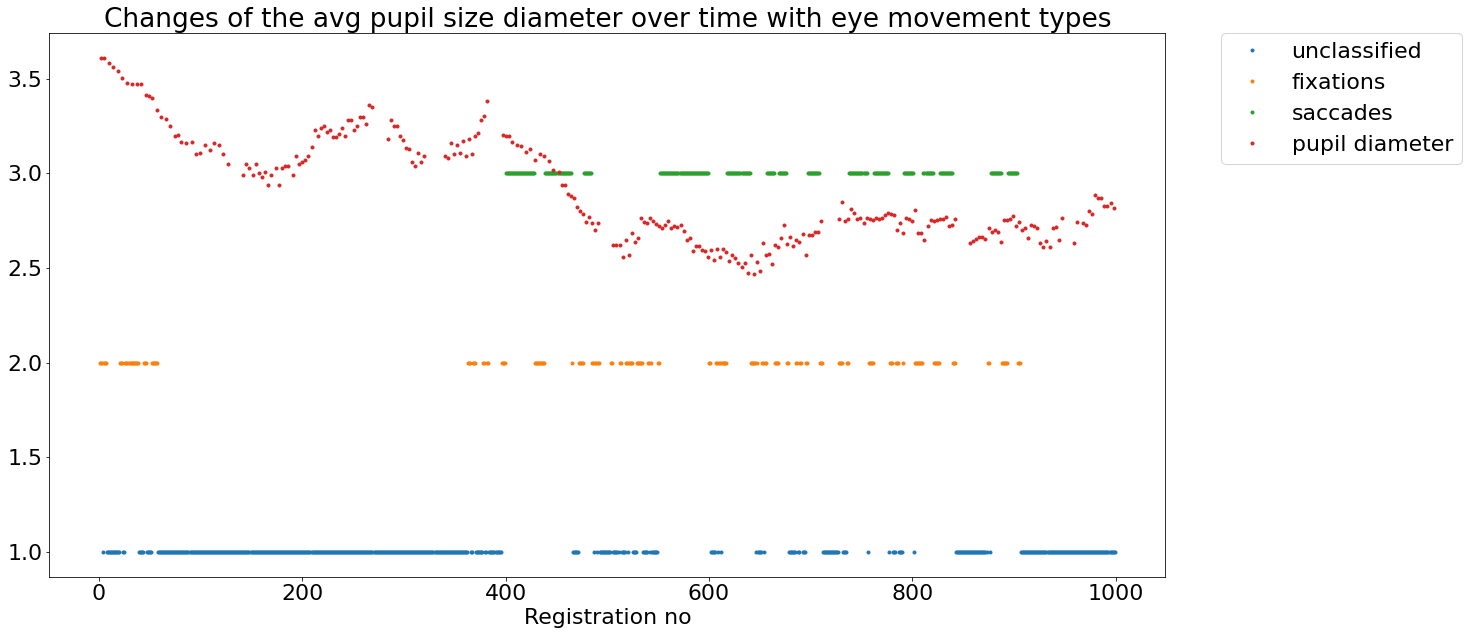

In [20]:
data_all_rows = all_participants_with_all_time_series_dict[7]["attempts"][2]["ts_df"]
data = data_all_rows[(data_all_rows["Index"] > 0) & (data_all_rows["Index"] <1000)]

data1= data.copy()
data2= data.copy()
data3= data.copy()

#data_unclassified = data.loc[data['Label'] == 1]
data1.loc[data1['Label']!=1,['Label']] = nan_value
data2.loc[data2['Label']!=2,['Label']] = nan_value
data3.loc[data3['Label']!=3,['Label']] = nan_value
data_no_null = data.loc[data['Pupil_diameter_mean_fixed'].notnull()]

font = { 'size'   : 22}
plt.rc('font', **font)
plt.figure(figsize=(20,10))
#plt.title(x)
plt.plot(data['Index'], data1['Label'],'.',  label='unclassified')
plt.plot(data['Index'], data2['Label'],'.',  label='fixations')
plt.plot(data['Index'], data3['Label'],'.',  label='saccades')
plt.plot(data_no_null['Index'], data_no_null['Pupil_diameter_mean_fixed'],'.', label ="pupil diameter" )

plt.title('Changes of the avg pupil size diameter over time with eye movement types')
#plt.ylabel('Pupil size (mm)')
plt.xlabel('Registration no')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# import csv

# #test
# with open('pupil_mean.csv', 'w') as f:
#     writer = csv.writer(f, delimiter="\n")
#     writer.writerows(zip(data_no_null['Index'], data_no_null['Pupil_diameter_mean_fixed']))
# ##

# # Write to xmgrace files
# path = "Data/xmgrace/slice_eye_movement_type_with_pupil_diameter"
# #print(data['Index'])

# pd.DataFrame([data['Index'],data1['Label']]).to_csv(create_file(path,'unclassified.txt'), sep="\n", index=False)
# pd.DataFrame([data['Index'],data2['Label']]).to_csv(create_file(path,'fixations.txt'), sep="\n", index=False)
# pd.DataFrame([data['Index'],data3['Label']]).to_csv(create_file(path,'saccades.txt'), sep="\n", index=False)
# pd.DataFrame([data_no_null['Index'],data_no_null['Pupil_diameter_mean_fixed']]).to_csv(create_file(path,'pupil_mean.txt'), sep="\n", index=False)
#np.set_printoptions(suppress=True)
#np.set_printoptions(precision=3)



# x_arr = np.array(data['Index']).astype(int)
# y_arr = np.array(data1['Label'])
# dat = np.array([x_arr, y_arr])

# #print(x_arr)
# print(y_arr)
# #print(dat)
# a= np.column_stack((dat))
# np.savetxt(create_file(path,'unclassified.dat'), a, delimiter=' ',fmt='%f')

### Display pupil diameter changes

FIG A2

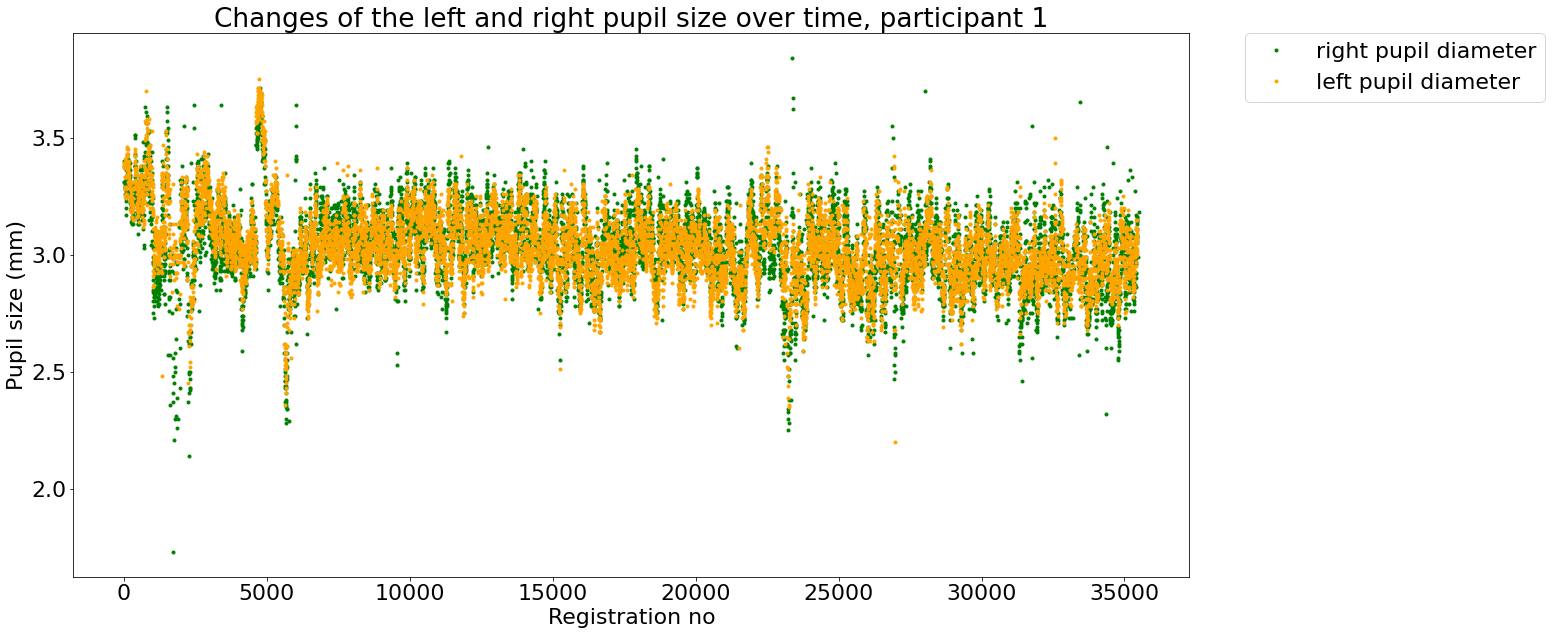

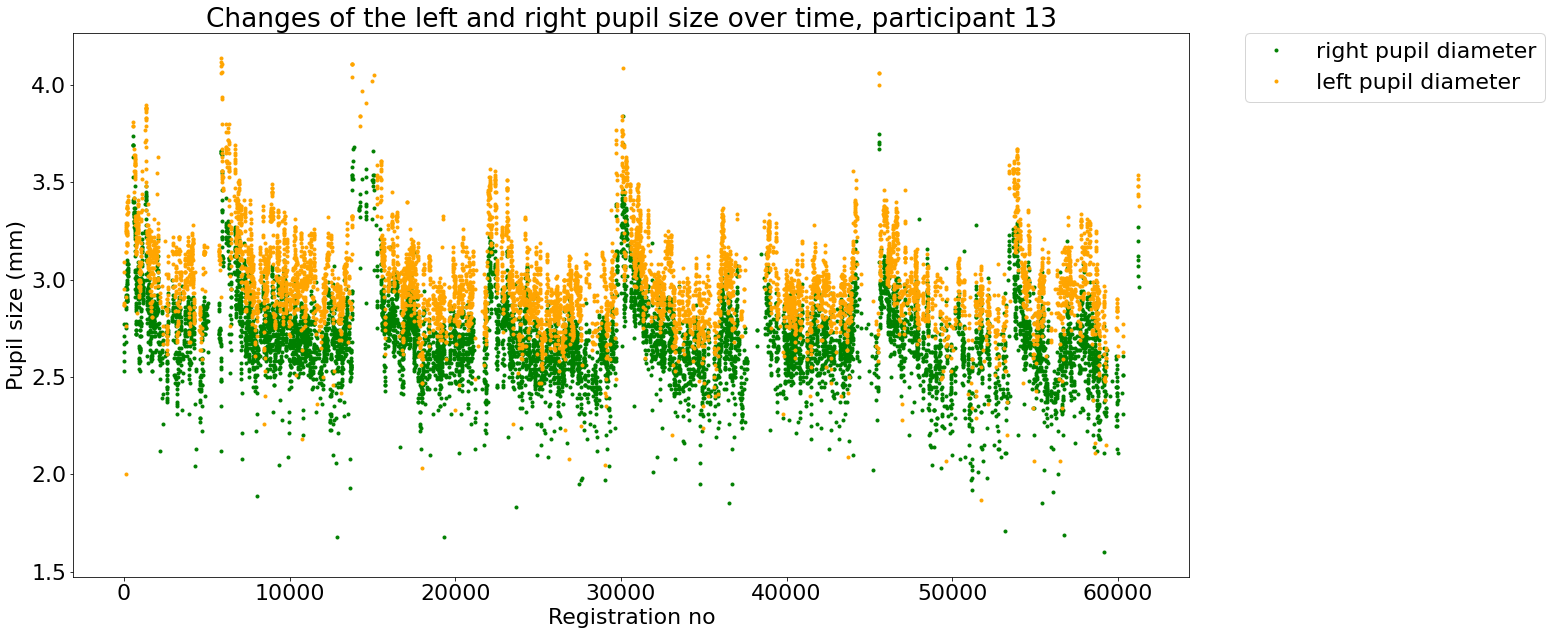

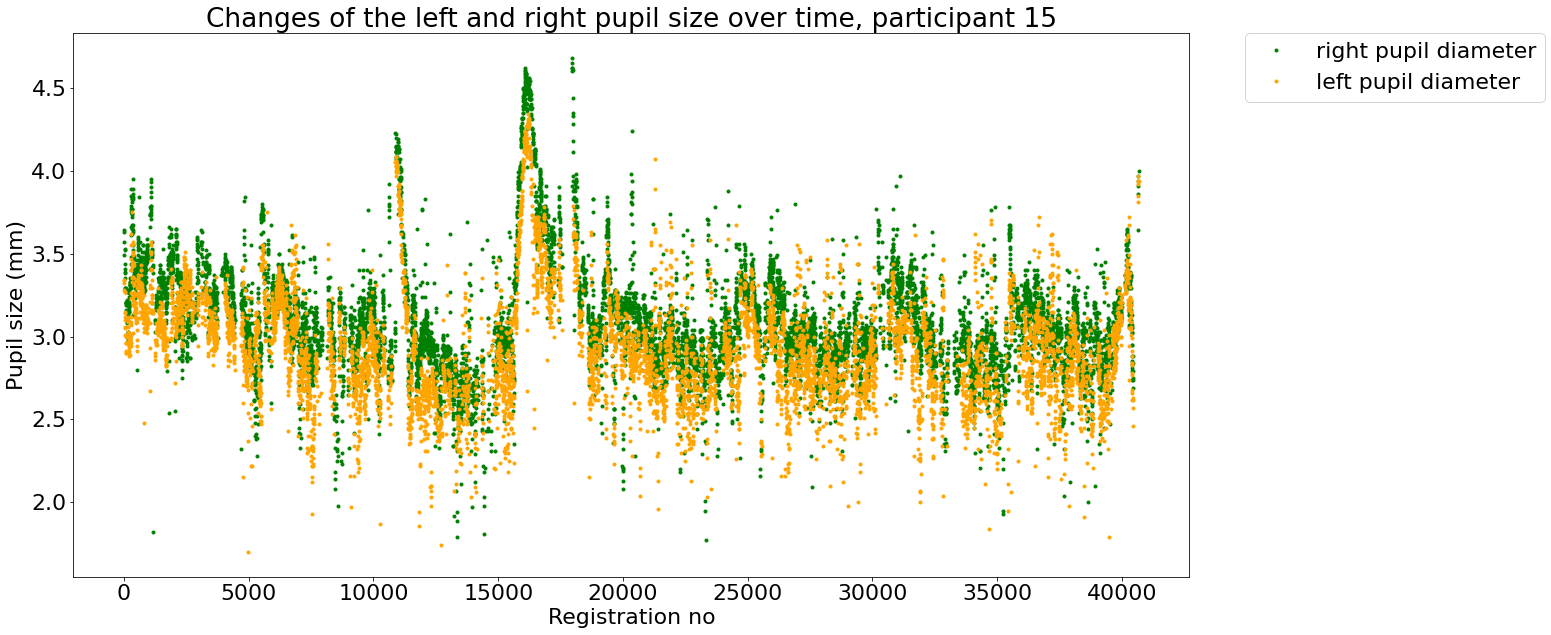

In [21]:
for i in range(3):

    df_p_5_ts_5 =all_participants_with_all_time_series_dict[i]["attempts"][7]["ts_df"]

    data_filtered = df_p_5_ts_5.loc[df_p_5_ts_5['Pupil diameter right'].notnull()]
    #display(data_filtered)
    #print(data_filtered.info())
    font = {'size':22}
    plt.rc('font', **font)
    plt.figure(figsize=(20,10))
    plt.plot(data_filtered['Index'], data_filtered['Pupil diameter right'], '.', label='right pupil diameter', color ="green")
    plt.plot(data_filtered['Index'], data_filtered['Pupil diameter left'], '.', label='left pupil diameter',color = "orange")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.title('Changes of the left and right pupil size over time, participant ' + all_participants_with_all_time_series_dict[i]["number"])
    plt.ylabel('Pupil size (mm)')
    plt.xlabel('Registration no')

    # Write to xmgrace files
    # path = "Data/xmgrace/pupil_diameter_changes_left_right"

    # pd.DataFrame([data_filtered['Index'],data_filtered['Pupil diameter right']]).to_csv(create_file(path,'diameter_left.csv'), sep=",", index=False)
    # pd.DataFrame([data_filtered['Index'], data_filtered['Pupil diameter left']]).to_csv(create_file(path,'diameter_right.csv'), sep=",", index=False)

### Check the diameter differences 
$$
\Delta D, \bar{D}, \frac{\Delta D}{\bar{D}}
$$

In [22]:
df_p_5_ts_5[['Pupil_diameter_D','Pupil_diameter_mean','Pupil_diameter_p']].describe()

,Pupil_diameter_D,Pupil_diameter_mean,Pupil_diameter_p
count,7620.000000,7620.000000,7620.000000
mean,0.252392,3.038465,0.084324
std,0.183116,0.312330,0.063689
min,0.000000,2.245000,0.000000
25%,0.130000,2.835000,0.041456
50%,0.220000,2.995000,0.072214
75%,0.340000,3.185000,0.110307
max,1.680000,4.435000,0.585366


### Check not null left and right pupil diameter

In [23]:
# rows = len(df_p_5_ts_5)
# nan_left = df_p_5_ts_5['Pupil diameter left'].isna().sum()

# print("% NaN left eye")
# print(nan_left/rows)

# nan_right = df_p_5_ts_5['Pupil diameter right'].isna().sum()

# print("% NaN right eye")
# print(nan_right/rows)

# nan_mean = df_p_5_ts_5['Pupil_diameter_mean'].isna().sum()

# print("% NaN mean")
# print(nan_mean/rows)

print("----------------------------")

# all_df = pd.read_csv(file_path,"\t", na_values='.', low_memory=False) #Read participant-file to a dataframe
# rows_all = len(all_df)

# nan_left_all = all_df['Pupil diameter left'].isna().sum()

# print("% NaN left eye")
# print(nan_left_all/rows_all)

# nan_right_all = all_df['Pupil diameter right'].isna().sum()

# print("% NaN right eye")
# print(nan_right_all/rows_all)

# nan_mean_all = all_df['Pupil_diameter_mean'].isna().sum()

# print("% NaN mean")
# print(nan_mean_all/rows_all)
sum = 0
for participant in all_participants:
    
    
    df = participant
    rows_all = len(df)

    nan_left_all = df['Pupil diameter left'].isna().sum()

    #print("% NaN left eye")
    #print(nan_left_all/rows_all)

    nan_right_all = df['Pupil diameter right'].isna().sum()

    #print("% NaN right eye")
    #print(nan_right_all/rows_all)

    nan_mean_all = df['Pupil_diameter_mean'].isna().sum()

    #print("% NaN mean ")
    #print(nan_mean_all/rows_all)

    nan_left_fixed = df['Pupil diameter left fixed'].isna().sum()

    #print("% NaN left eye fixed")
    #print(nan_left_fixed/rows_all)

    nan_right_fixed = df['Pupil diameter right fixed'].isna().sum()

    #print("% NaN right eye fixed")
    #print(nan_right_fixed/rows_all)

    nan_mean_fixed = df['Pupil_diameter_mean_fixed'].isna().sum()

    #print("% NaN mean fixed")
   # print(nan_mean_fixed/rows_all)

    result = (nan_right_all/rows_all) - (nan_mean_fixed/rows_all)
    print(result)
    sum = sum + result
    print("----------------------------")

print("less nans total")
print(len(all_participants))
print(result/len(all_participants))


----------------------------
0.004921212121212104
----------------------------
0.08013539696275818
----------------------------
0.020753410352522206
----------------------------
0.018707912689084005
----------------------------
0.05342477210002505
----------------------------
0.0032384849778458458
----------------------------
0.0249296026460466
----------------------------
0.015206467118199618
----------------------------
0.013493578618535285
----------------------------
0.028931197385713814
----------------------------
0.00919284604741577
----------------------------
0.03904817157615004
----------------------------
0.05547290116896908
----------------------------
0.006179836189988075
----------------------------
0.039304764856532226
----------------------------
0.07075706517576774
----------------------------
0.03030209807420159
----------------------------
0.011047789741938208
----------------------------
0.012267999337678526
----------------------------
0.07915646509908991
---------

### Scatterplot pupil diameters

def event_label (row):
   if row['Eye movement type'] == 'Unclassified' :
      return 1
   if row['Eye movement type'] == 'Saccade' :
      return 2
   if row['Eye movement type'] == 'Fixation' :
      return 3
   return 1

No handles with labels found to put in legend.


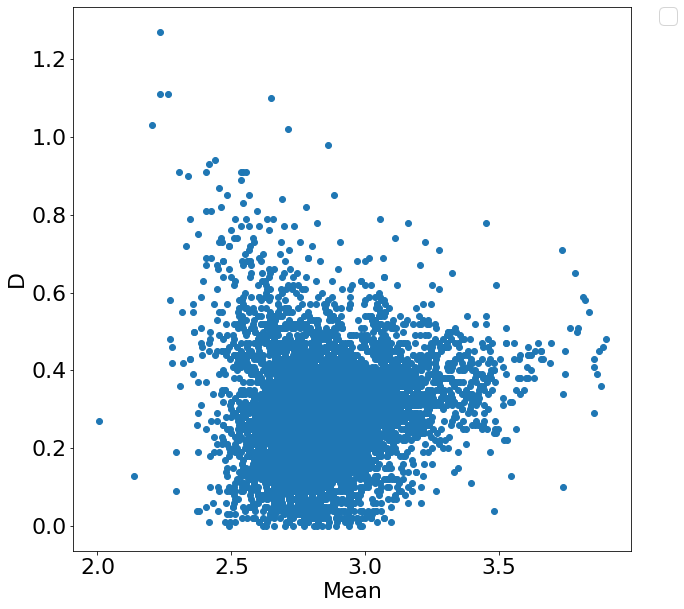

In [24]:
pa = all_participants_with_all_time_series_dict[1]["attempts"][7]["ts_df"]

plt.figure(figsize=(10,10))
plt.scatter(pa['Pupil_diameter_mean'], pa['Pupil_diameter_D'])
plt.xlabel("Mean")
plt.ylabel("D")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### Define function to scatter plot pupil diameter with eye movement labels marked with color

#### all eye movements in one without distinction of the types

In [34]:
def scatter_left_right(participant = 0, timeseries = 0):
    df_test_all_columns =  all_participants_with_all_time_series_dict[participant]["attempts"][timeseries]["ts_df"] 
    x = df_test_all_columns[['Pupil diameter left']].to_numpy()
    y = df_test_all_columns[['Pupil diameter right']].to_numpy()

    plt.figure(figsize=(10,10))

    plt.scatter(x, y, alpha=0.5, edgecolors='none')
    x_v = np.reshape(x, -1)
    y_v = np.reshape(y, -1)
    
 
    #plt.title('Pupil diameter right vs. pupil diameter left')
    plt.xlabel('Pupil diameter left (mm)')
    plt.ylabel('Pupil diameter right (mm)')
    plt.show()

    coef = np.ma.corrcoef(np.ma.masked_invalid(x_v), np.ma.masked_invalid(y_v))
    print("Correlation coefficient")
    print(coef)




#### all labels in one

In [26]:
def plot_pupil_diameter_with_eye_movement_type_color_all_in_one(participant = 0, timeseries = 0):
    df_test_all_columns = all_participants_with_all_time_series_dict[participant]["attempts"][timeseries]["ts_df"] 
    df_test = df_test_all_columns.loc[df_test_all_columns['Pupil_diameter_mean'].notnull()]

    movements = []
    colors = ['red', 'blue', 'green']
    labels = ['unlcassified', 'saccade', 'fixation']

    for x in range(1, 4):
        df = df_test.copy()
        df.loc[df['Label']!=x,['Label']] = nan_value #unclass
        not_null_label = df.loc[df['Label'].notnull()]
        movements.append(not_null_label)
        
  
    fig, ax = plt.subplots()
    fig.set_size_inches(20,20)
    for i in range(len(movements)):
        x = movements[i][['Pupil diameter left']].to_numpy()
        y = movements[i][['Pupil diameter right']].to_numpy()
        size =np.full(len(movements[i]), 20)
        ax.scatter(x, y, c=colors[i], label=labels[i],#s=size,
                 alpha=0.5, edgecolors='none')
    ax.legend()
    plt.show()

#### each label in own plot

In [27]:
def plot_pupil_diameter_with_eye_movement_type_color(participant = 0, timeseries = 0):
    df_test =  all_participants_with_all_time_series_dict[participant]["attempts"][timeseries]["ts_df"] 

    movements = []
    colors = ['red', 'blue', 'green']
    labels = ['unlcassified', 'saccades', 'fixations']

    for x in range(1, 4):
        df = df_test.copy()
        df.loc[df['Label']!=x,['Label']] = nan_value #unclass
        not_null_label = df.loc[df['Label'].notnull()]
        movements.append(not_null_label)


    for i in range(len(movements)):
        x = movements[i][['Pupil diameter left']].to_numpy()
        
        y = movements[i][['Pupil diameter right']].to_numpy()

        plt.figure(figsize=(10,10))
        size =np.full(len(movements[i]), 20)

        plt.scatter(x, y, c=colors[i], label=labels[i],#s=size,
        alpha=0.5, edgecolors='none')

        #plt.title('Pupil diameter right vs. pupil diameter left: ' + labels[i])
        plt.xlabel('Pupil diameter left (mm)')
        plt.ylabel('Pupil diameter right (mm)')
        #plt.legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', borderaxespad=0.)
        plt.show()

        x_v = np.reshape(x, -1)
        y_v = np.reshape(y, -1)
        coef = np.ma.corrcoef(np.ma.masked_invalid(x_v), np.ma.masked_invalid(y_v))
        print("Correlation coefficient: " + labels[i])
        print(coef)

### Scatter plot of the diameter with the eye movement labels for task each for each participant

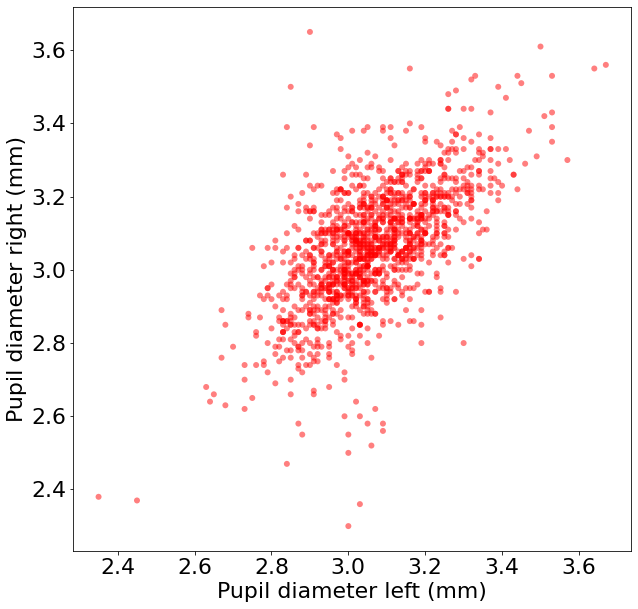

Correlation coefficient: unlcassified
[[1.0 0.6191629880170799]
 [0.6191629880170799 1.0]]


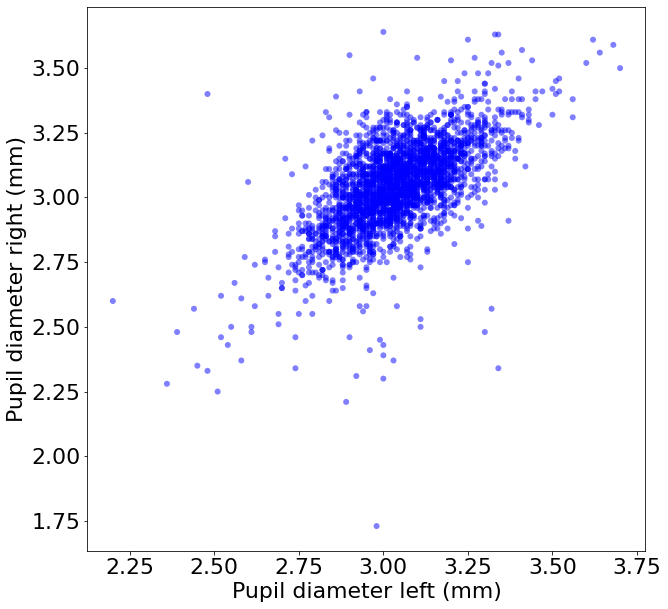

Correlation coefficient: saccades
[[1.0 0.6204398060294473]
 [0.6204398060294473 1.0]]


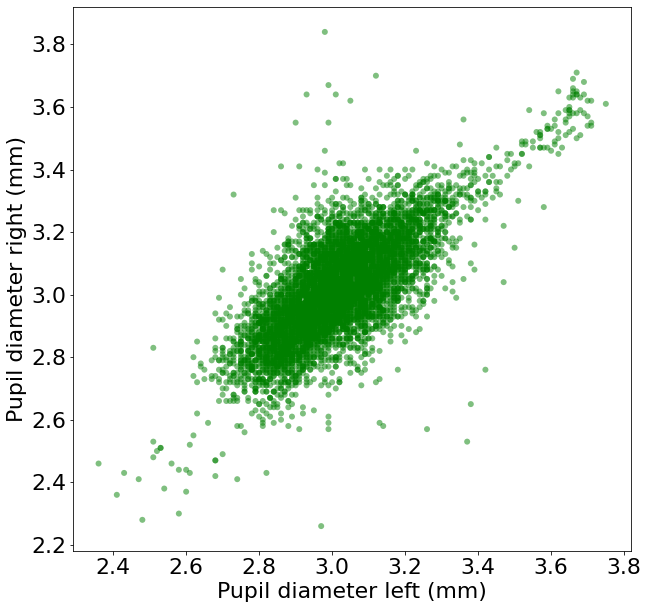

Correlation coefficient: fixations
[[1.0 0.7360783514205665]
 [0.7360783514205665 1.0]]


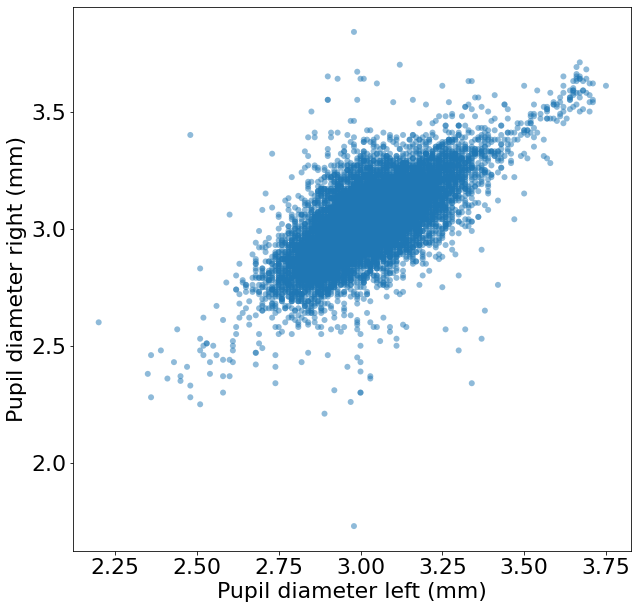

Correlation coefficient
[[1.0 0.693934938631814]
 [0.693934938631814 1.0]]


In [35]:
for i in range(1):
    plot_pupil_diameter_with_eye_movement_type_color(i, 7)
    #plot_pupil_diameter_with_eye_movement_type_color_all_in_one(i, 7)
    scatter_left_right(i, 7)

### Empathy scores before and after, scatter for all participants

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[108.0, 86.0, 104.0, 99.0, 100.0, 86.0, 106.0, 100.0, 90.0, 107.0, 79.0, 111.0, 108.0, 87.0, 103.0, 97.0, 83.0, 92.0, 96.0, 75.0, 80.0, 90.0, 109.0, 103.0]


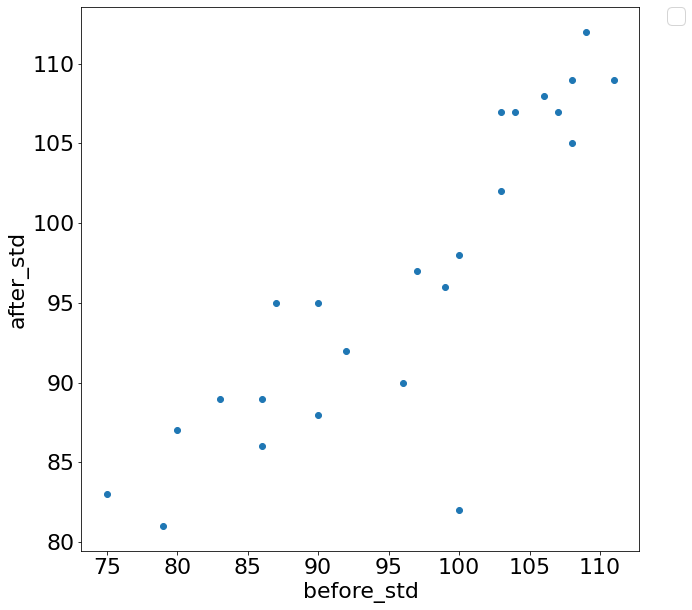

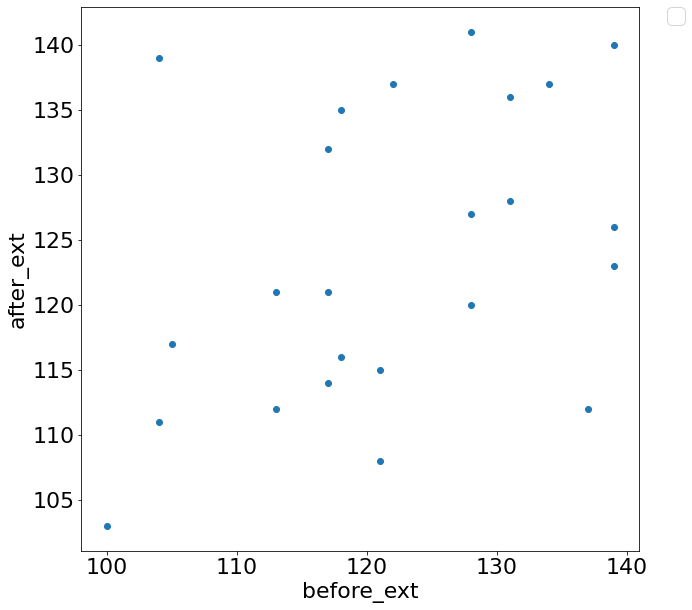

In [29]:
before_std = []
after_std = []
before_ext = []
after_ext = []

for participant in all_participants_with_all_time_series_dict:
    before_std.append(participant['empathy_before_std'])
    before_ext.append(participant['empathy_before_ext'])
    after_std.append(participant['empathy_after_std'])
    after_ext.append(participant['empathy_after_ext'])

print(before_std)
    
plt.figure(figsize=(10,10))
plt.scatter(before_std, after_std)
plt.xlabel("before_std")
plt.ylabel("after_std")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.figure(figsize=(10,10))
plt.scatter(before_ext, after_ext)
plt.xlabel("before_ext")
plt.ylabel("after_ext")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)



### Average pupil size during eacch of the 8 attempts for all the participants

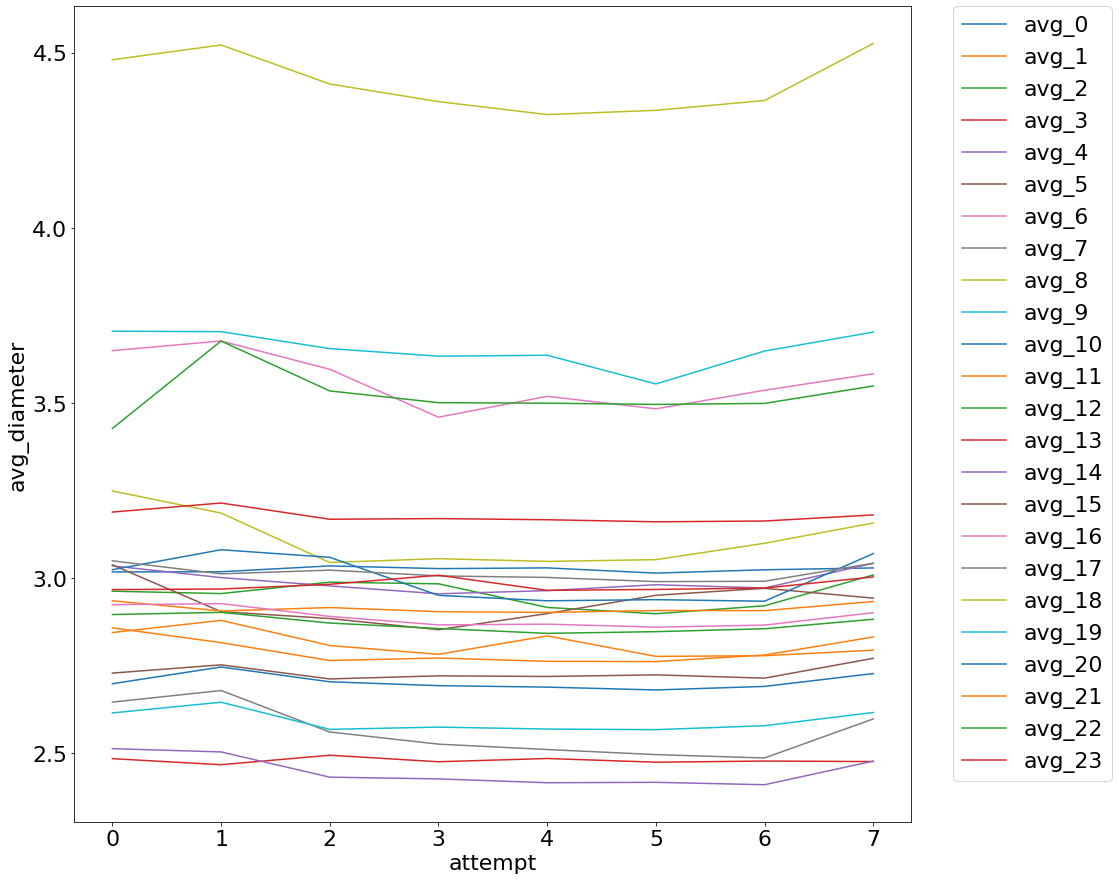

In [30]:
x = range(8)
all_avg = []
for participant in all_participants_with_all_time_series_dict:
    attempt_pupil_avg = []
    for attempt in participant['attempts']:
        attempt_pupil_avg.append(attempt['ts_mean'])
    all_avg.append(attempt_pupil_avg)
    # add all std deviation 

plt.figure(figsize=(15,15))
for i in range(len(all_avg)):
    plt.plot(x, all_avg[i], '-', label='avg_'+ str(i))
    #plt.plot(data_filtered['Index'], data_filtered['Pupil diameter left'], 'o', label='left')
    plt.xlabel("attempt")
    plt.ylabel("avg_diameter")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #plt.figure(figsize=(30,20))



### Pupil diameter average with empaty score for each participant

<ipython-input-31-b582ea612f1c>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(30,10))


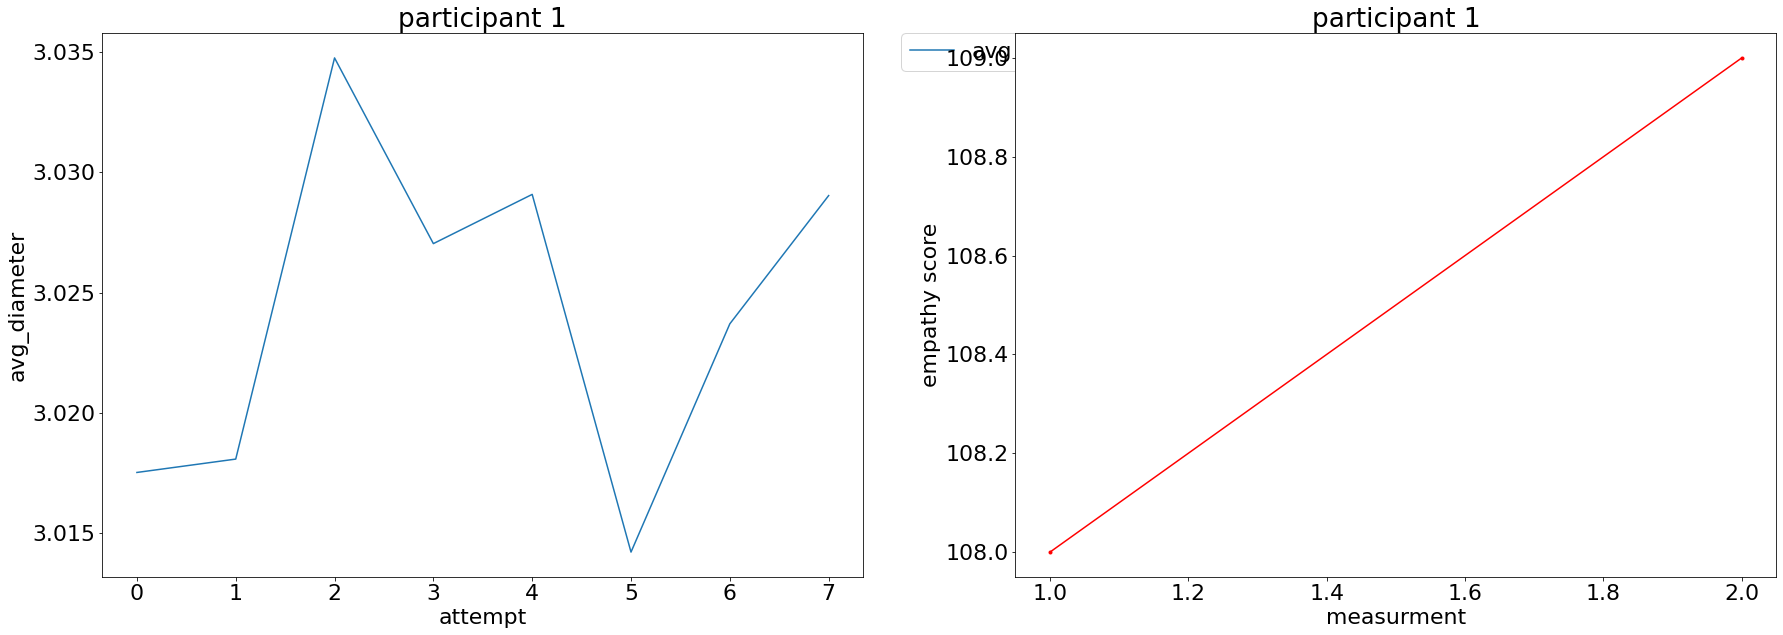

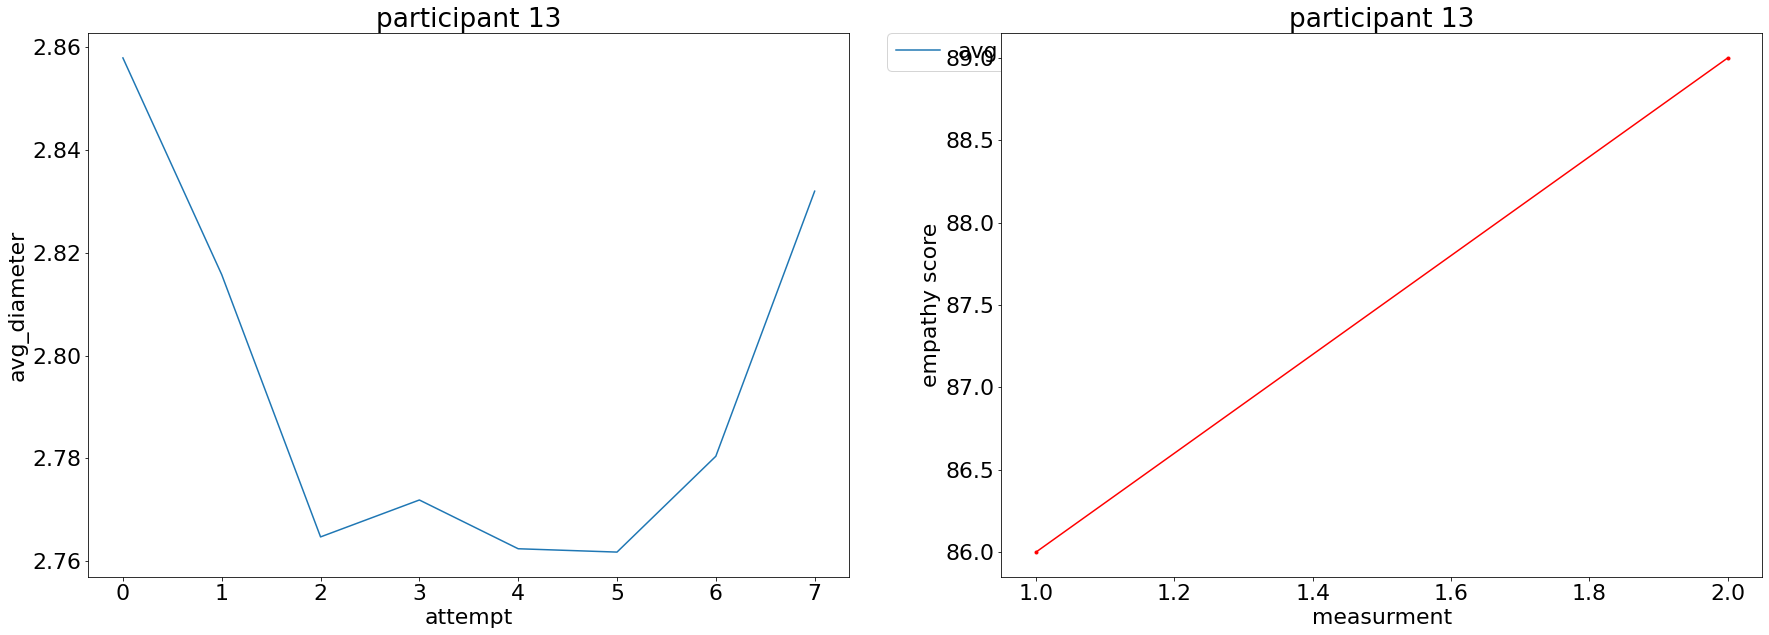

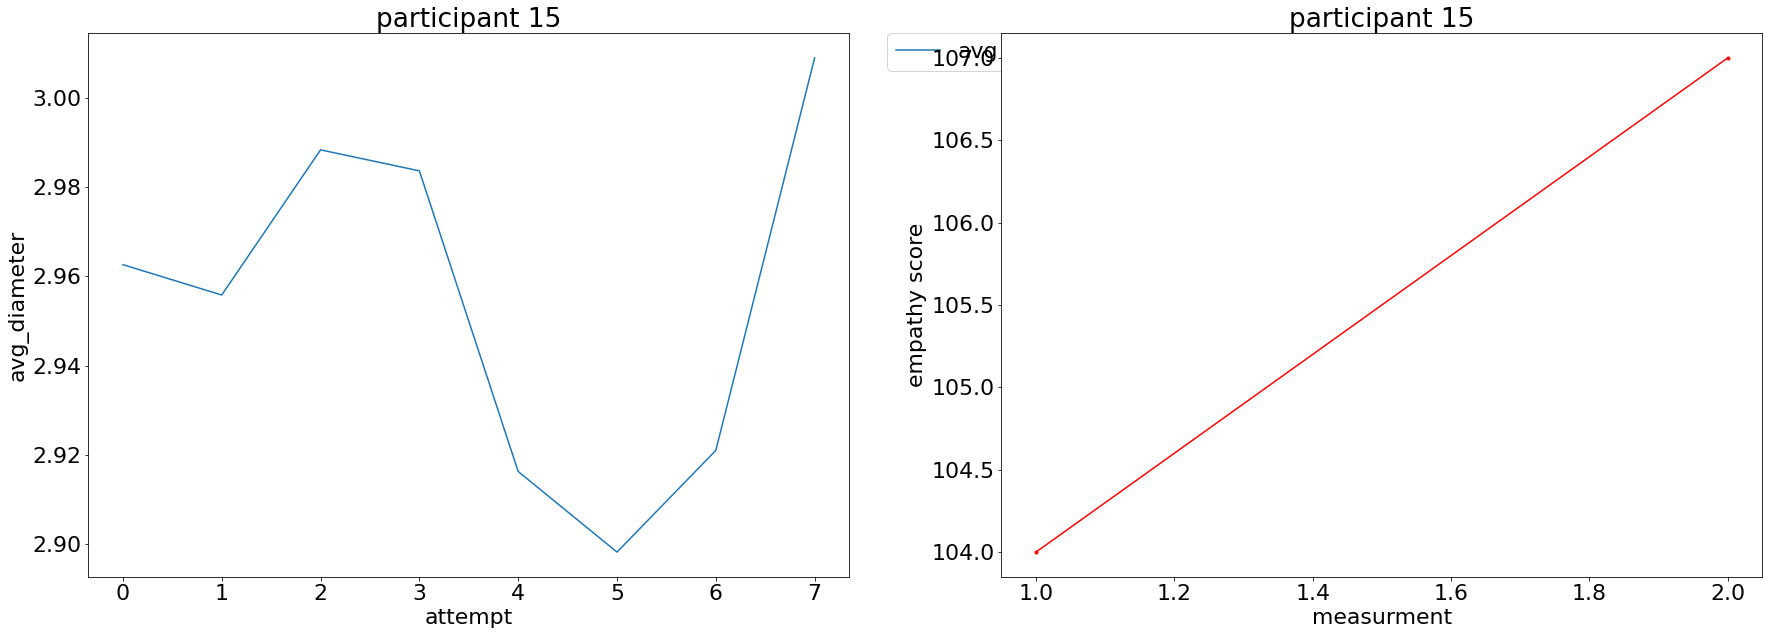

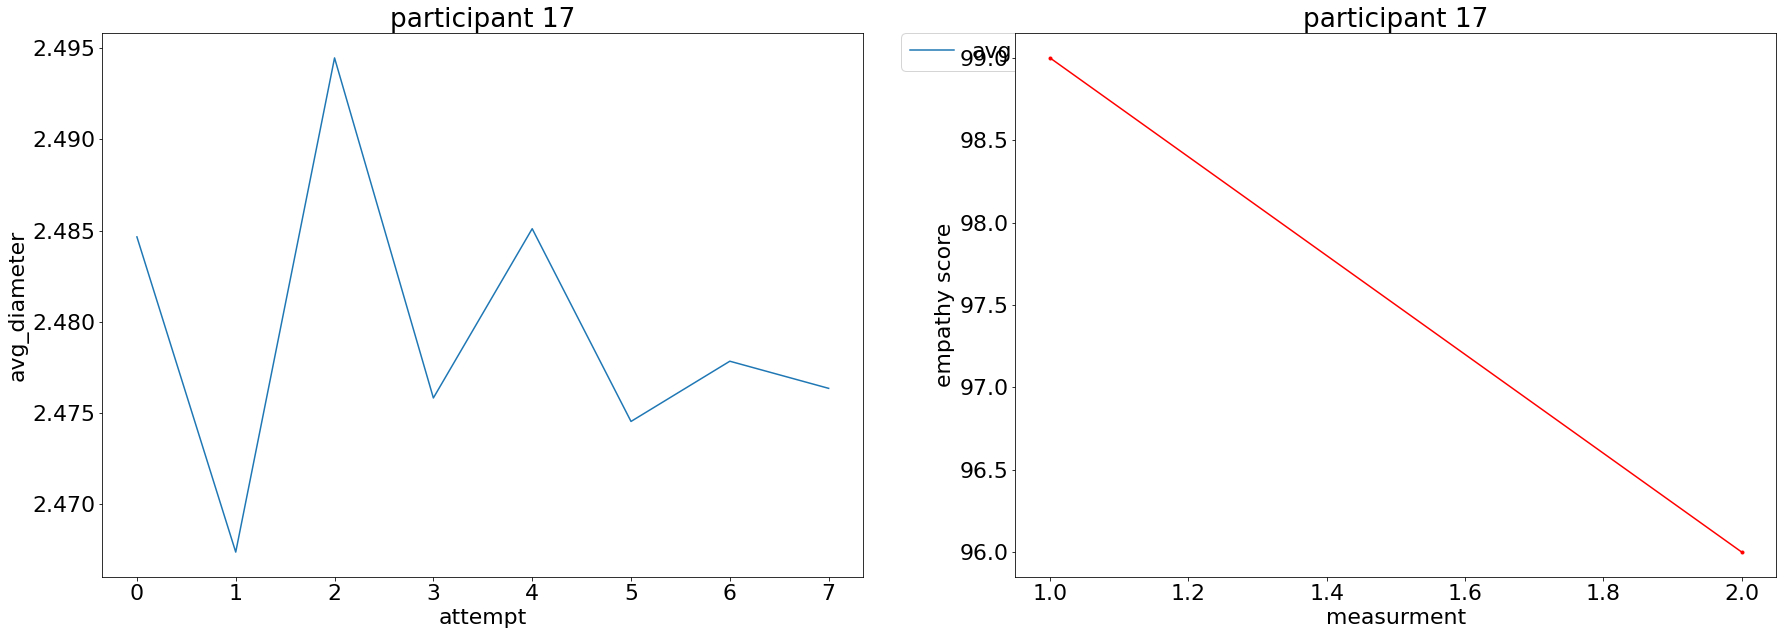

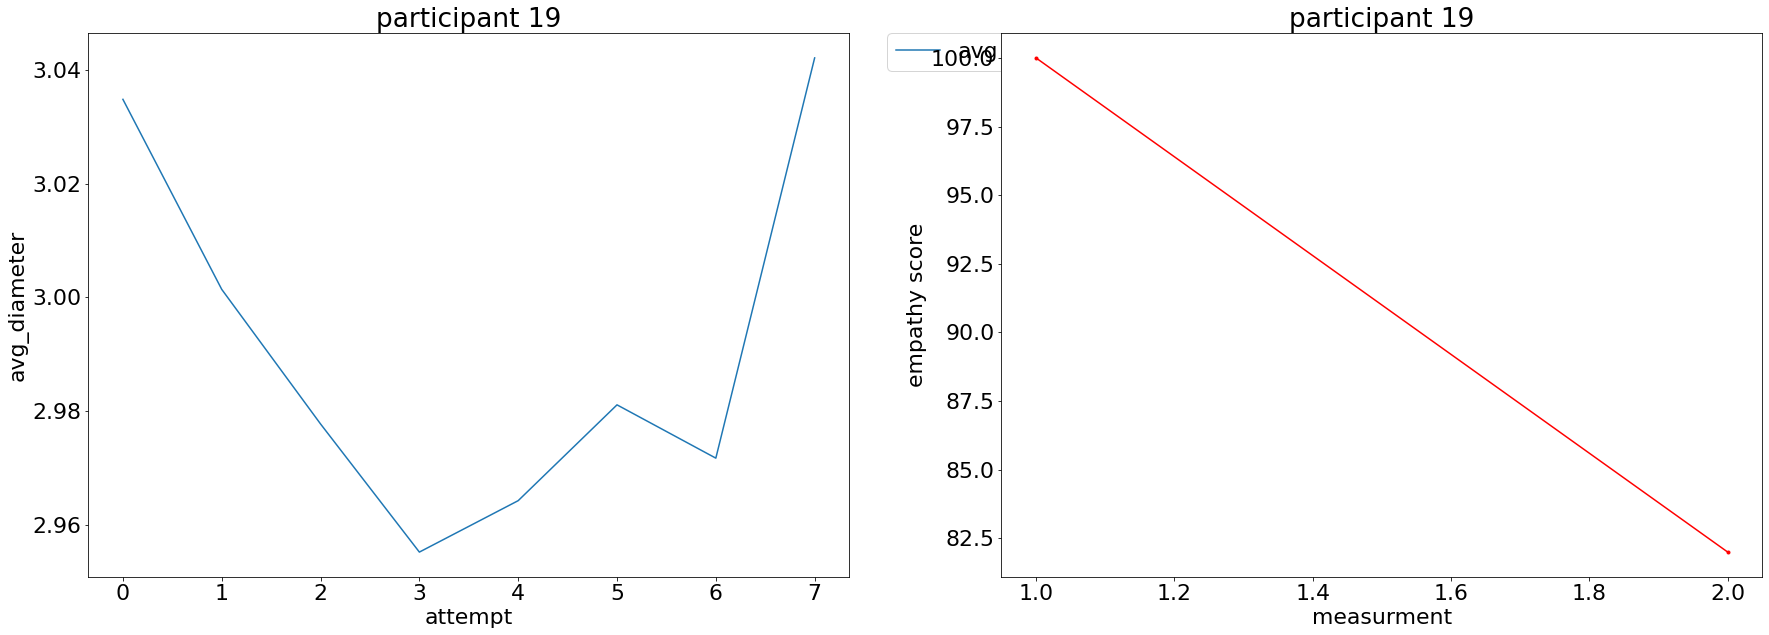

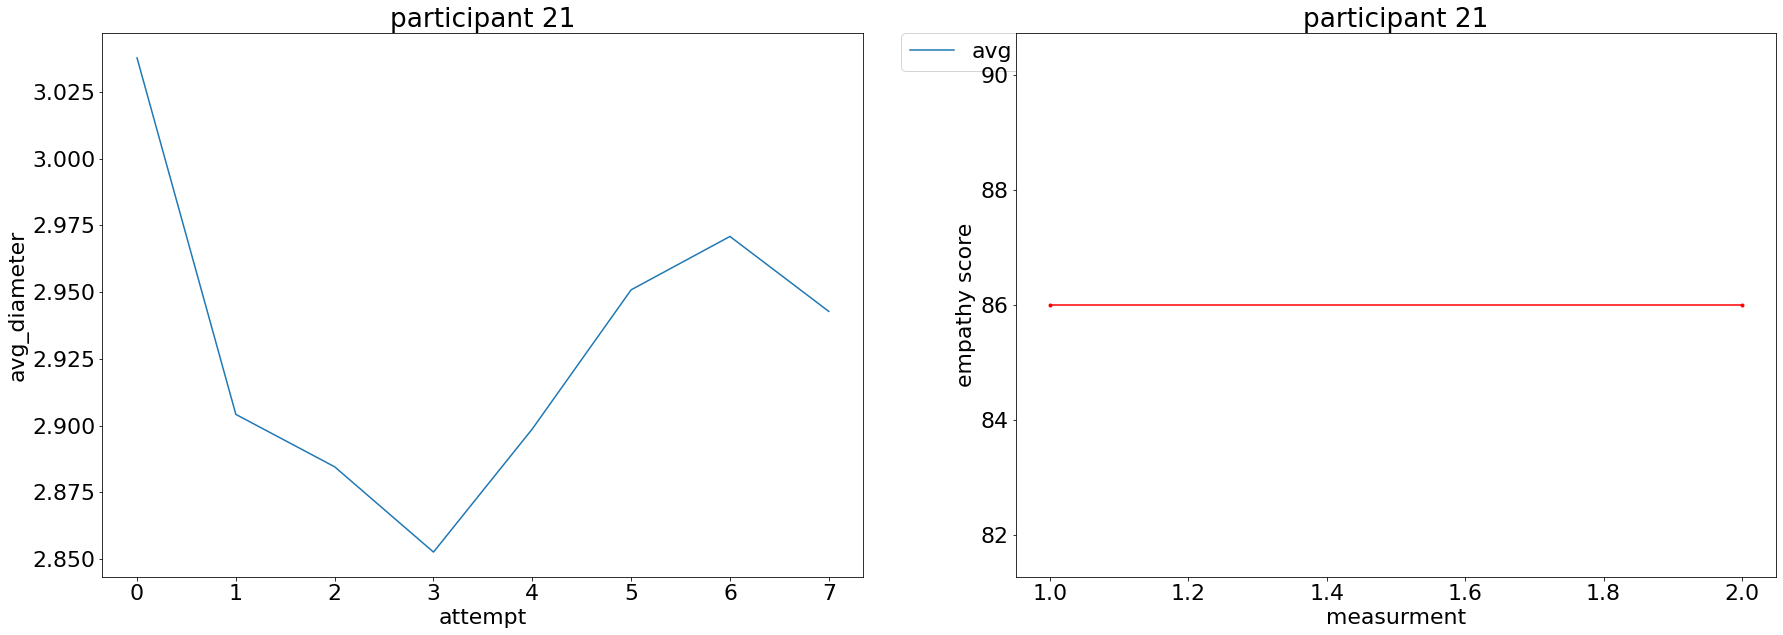

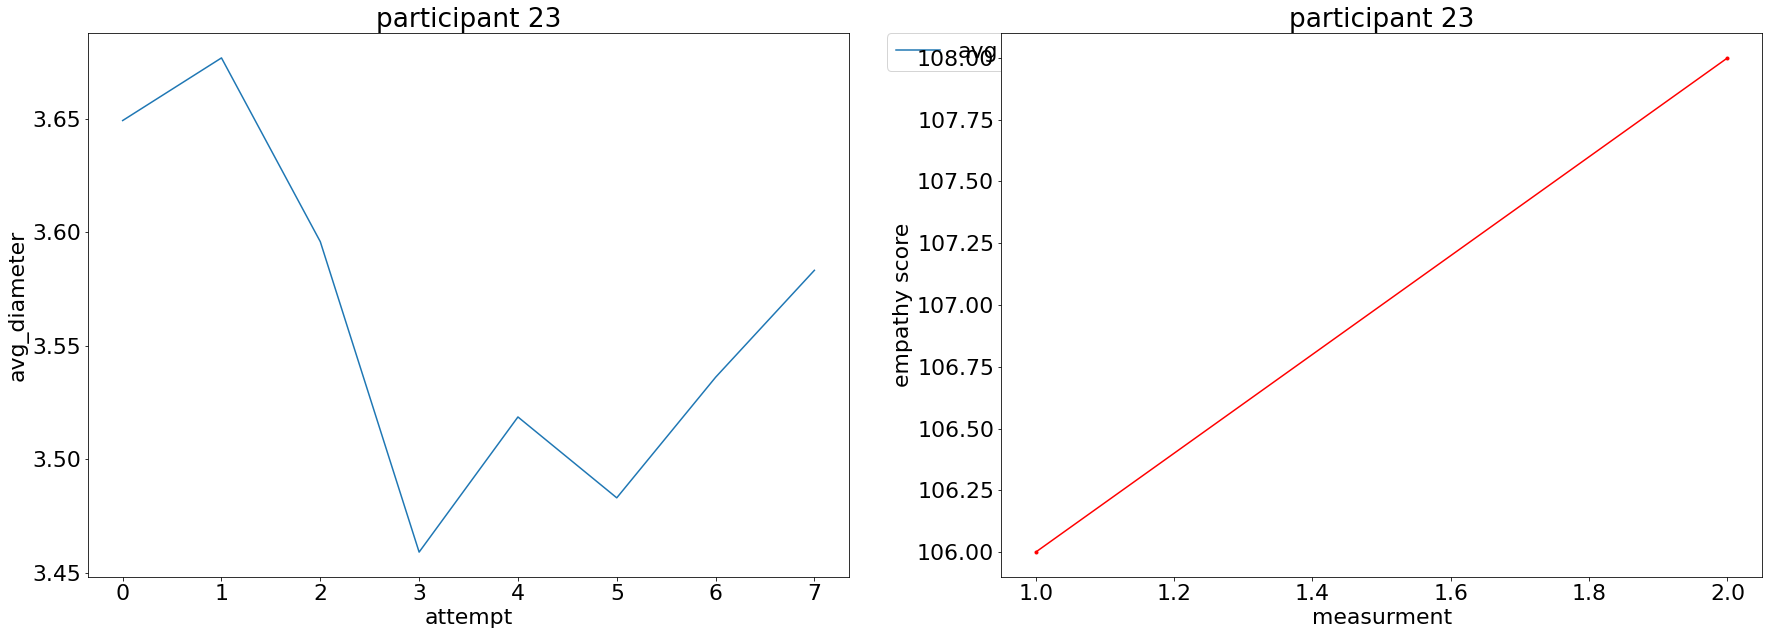

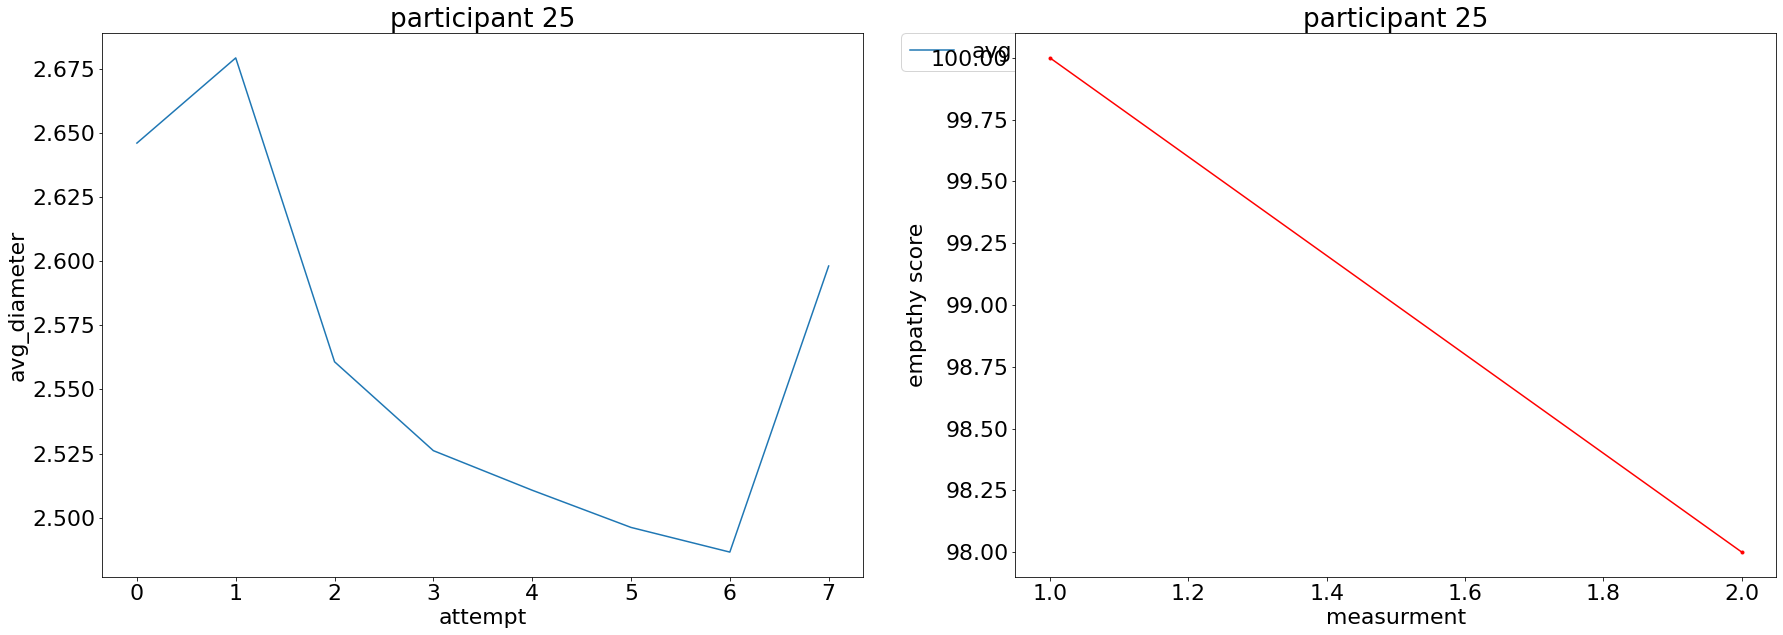

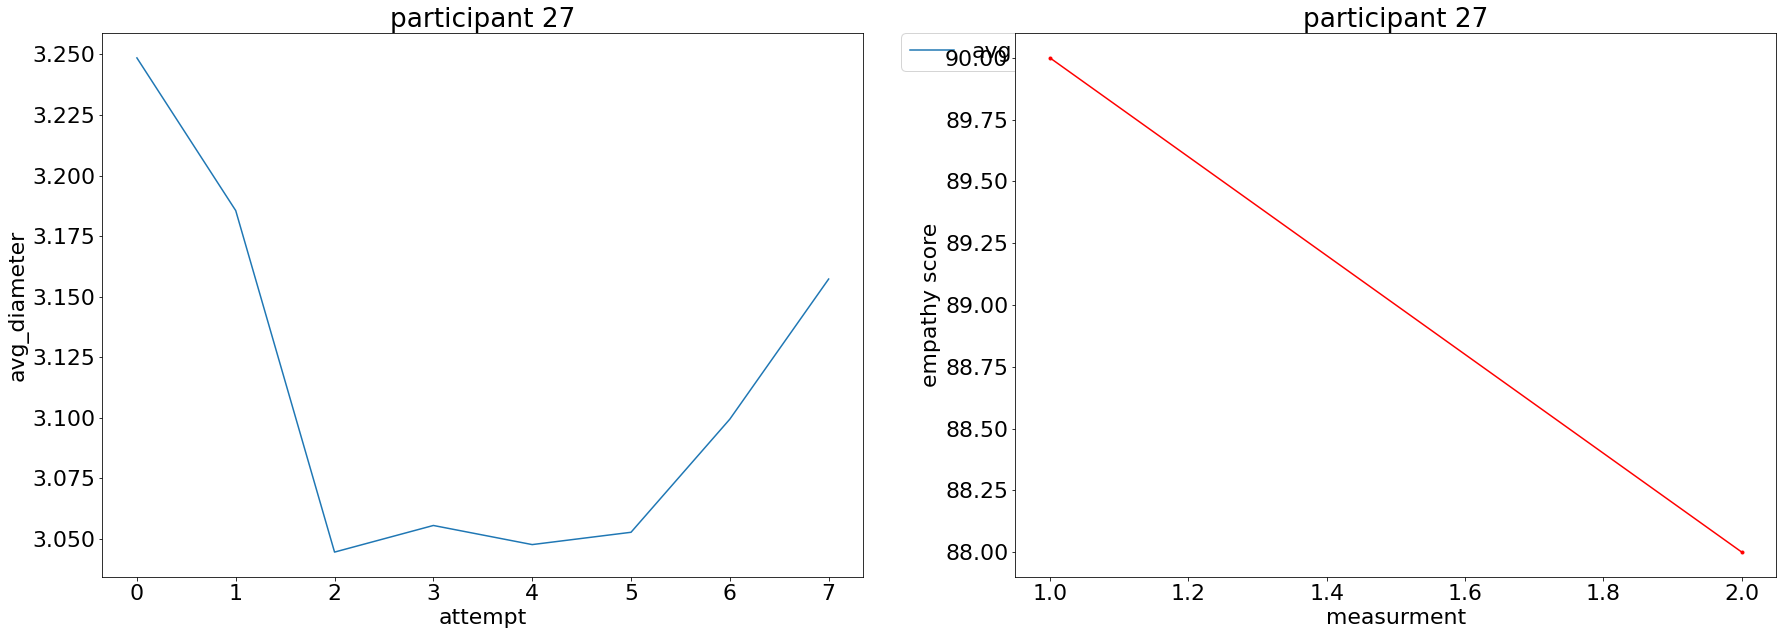

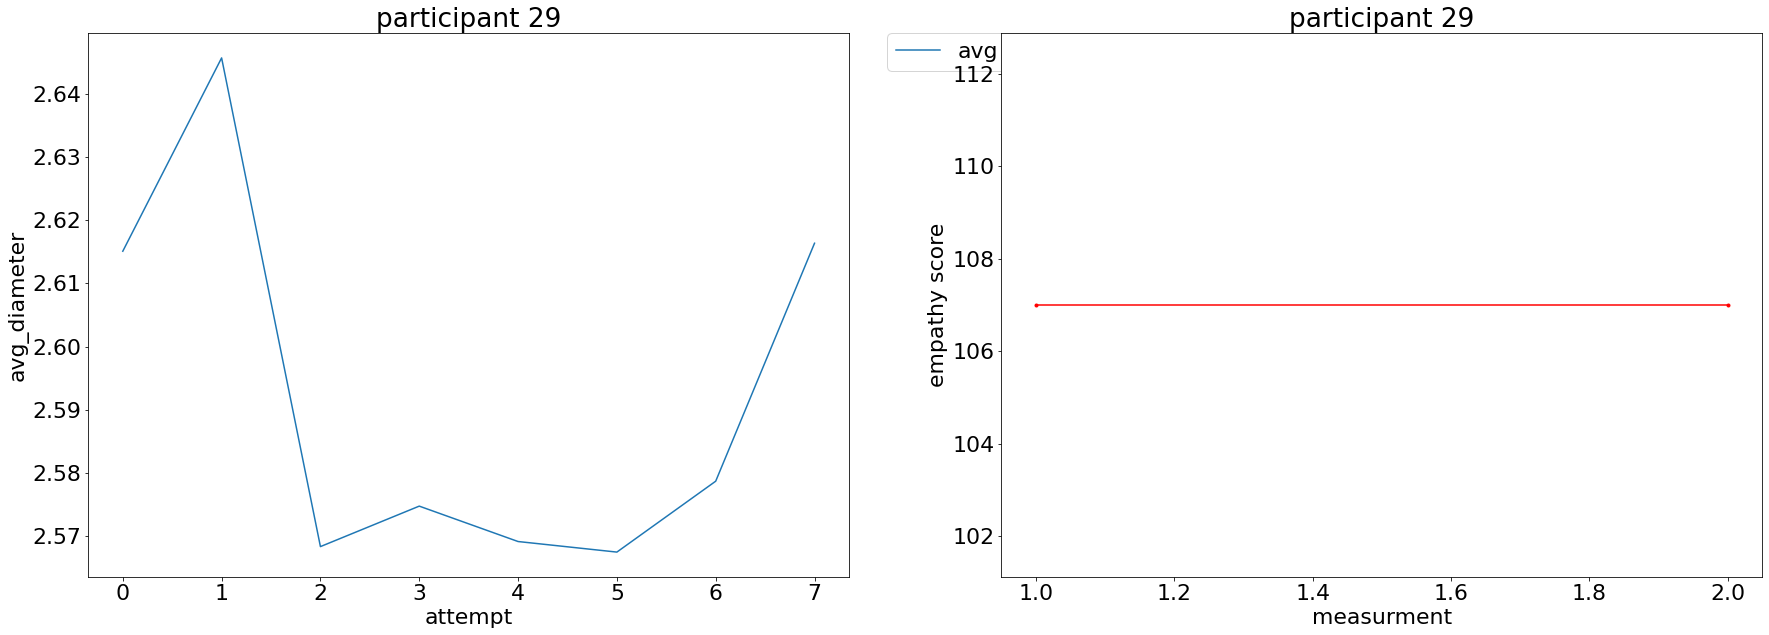

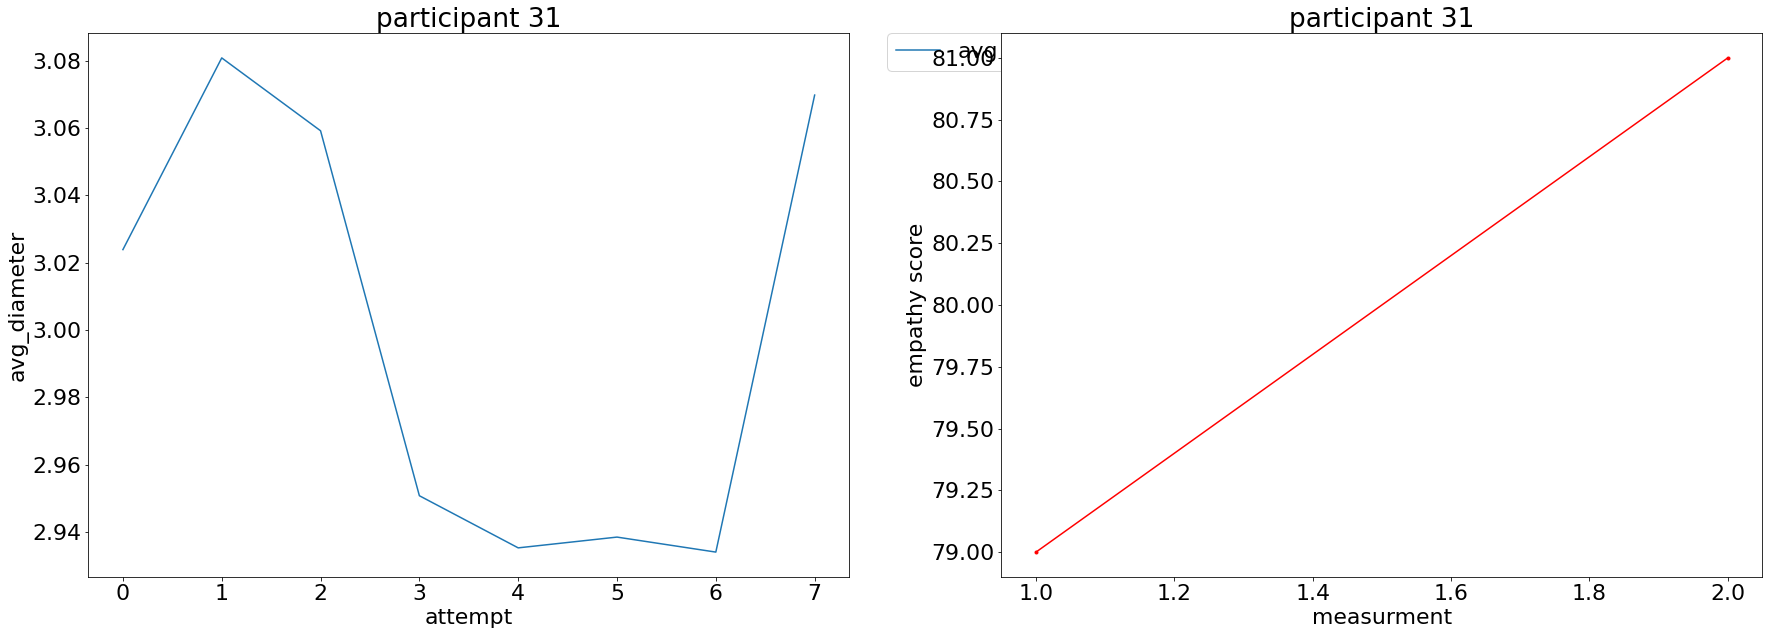

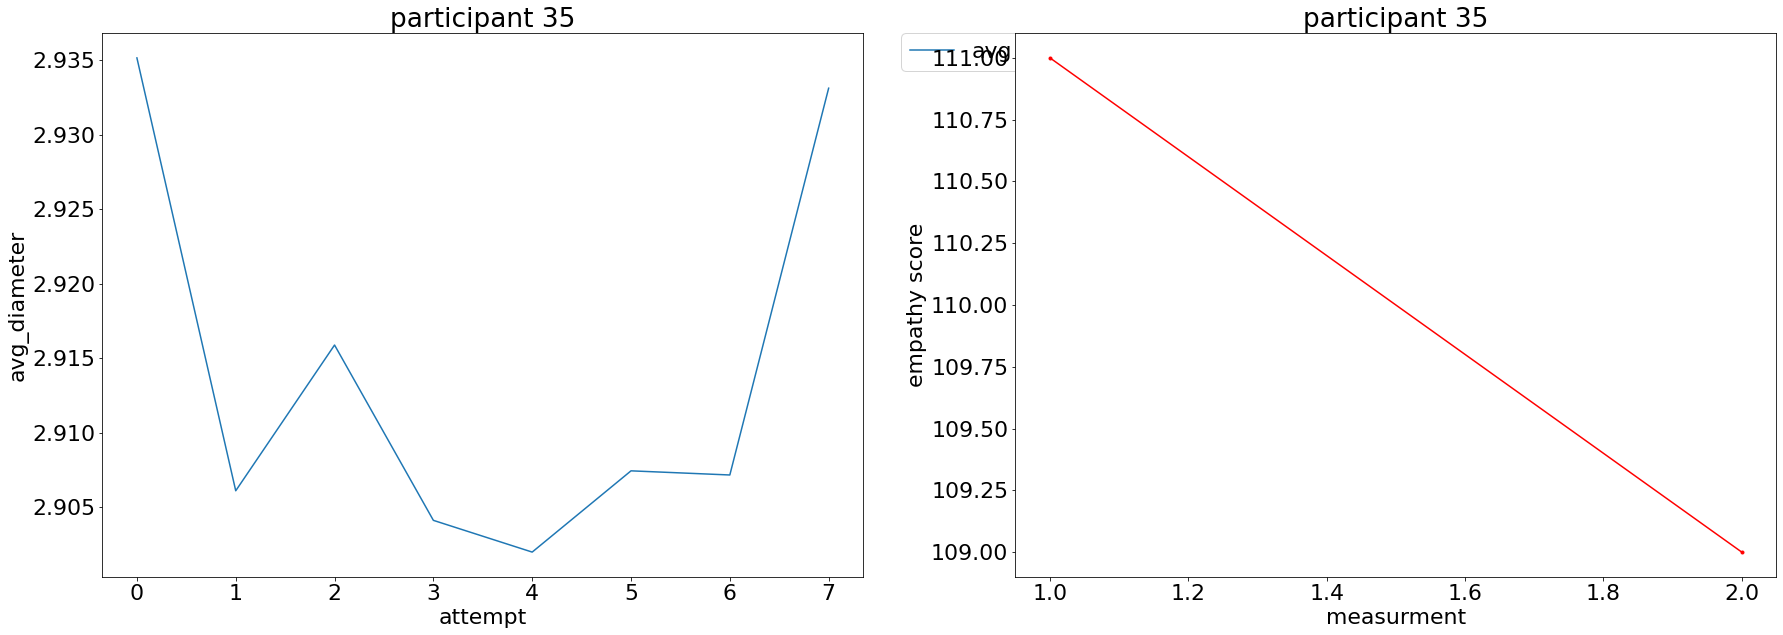

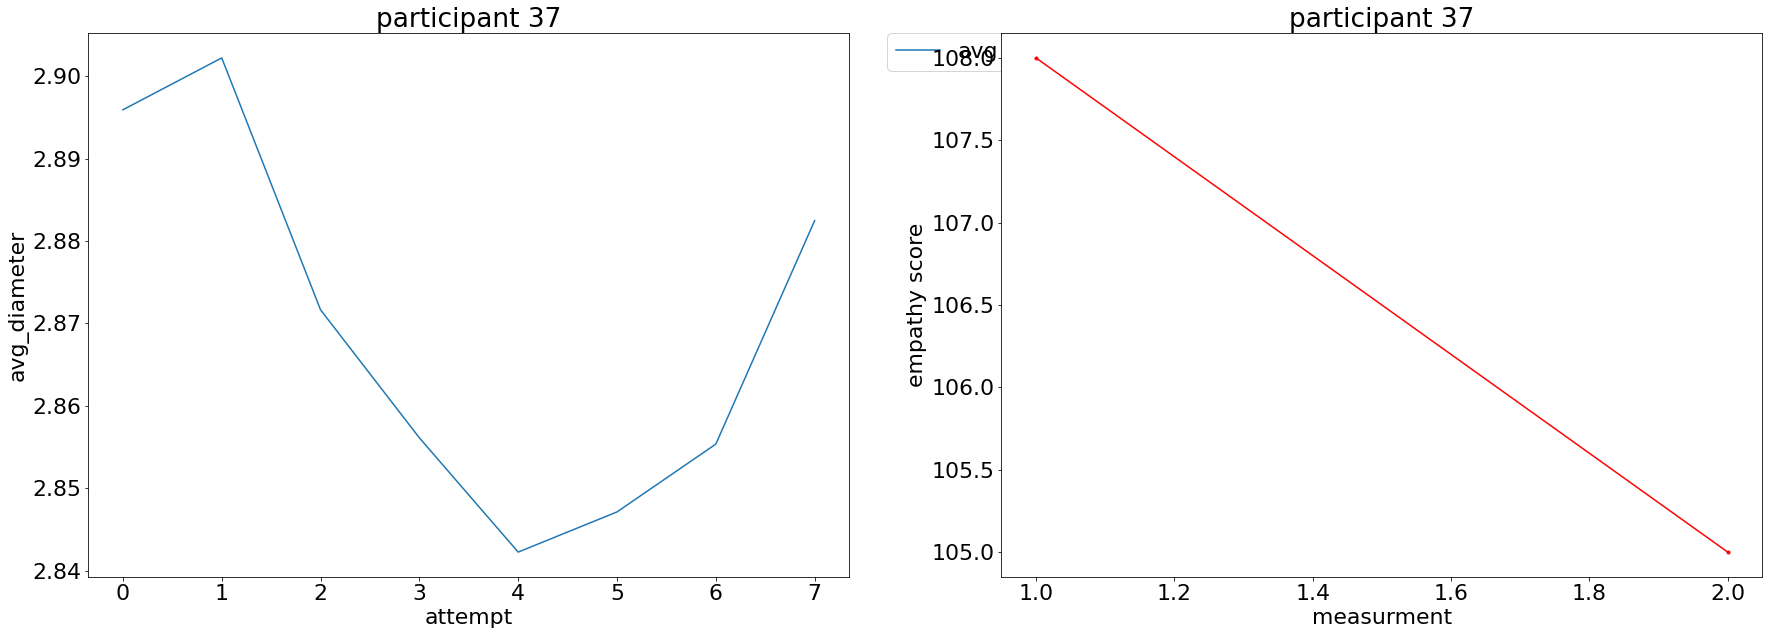

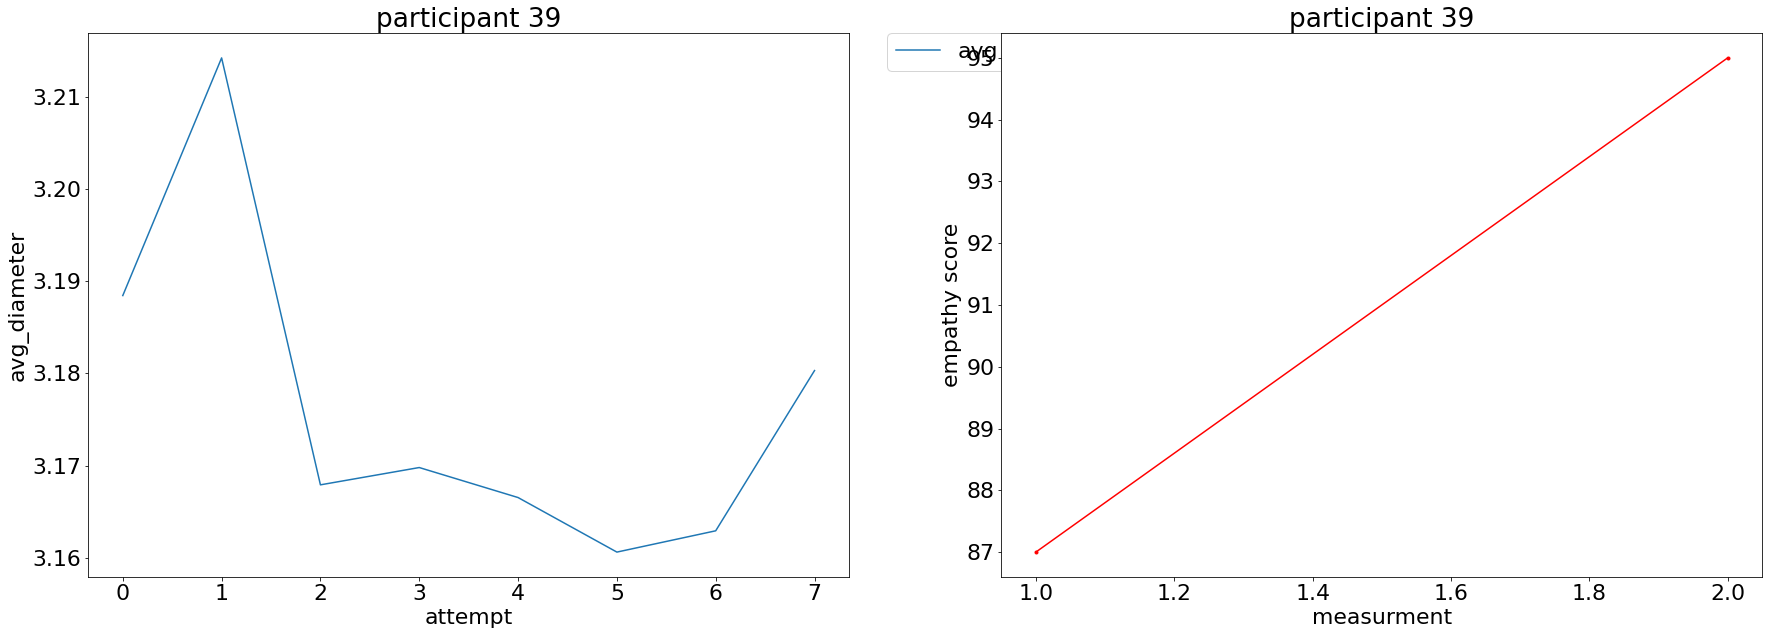

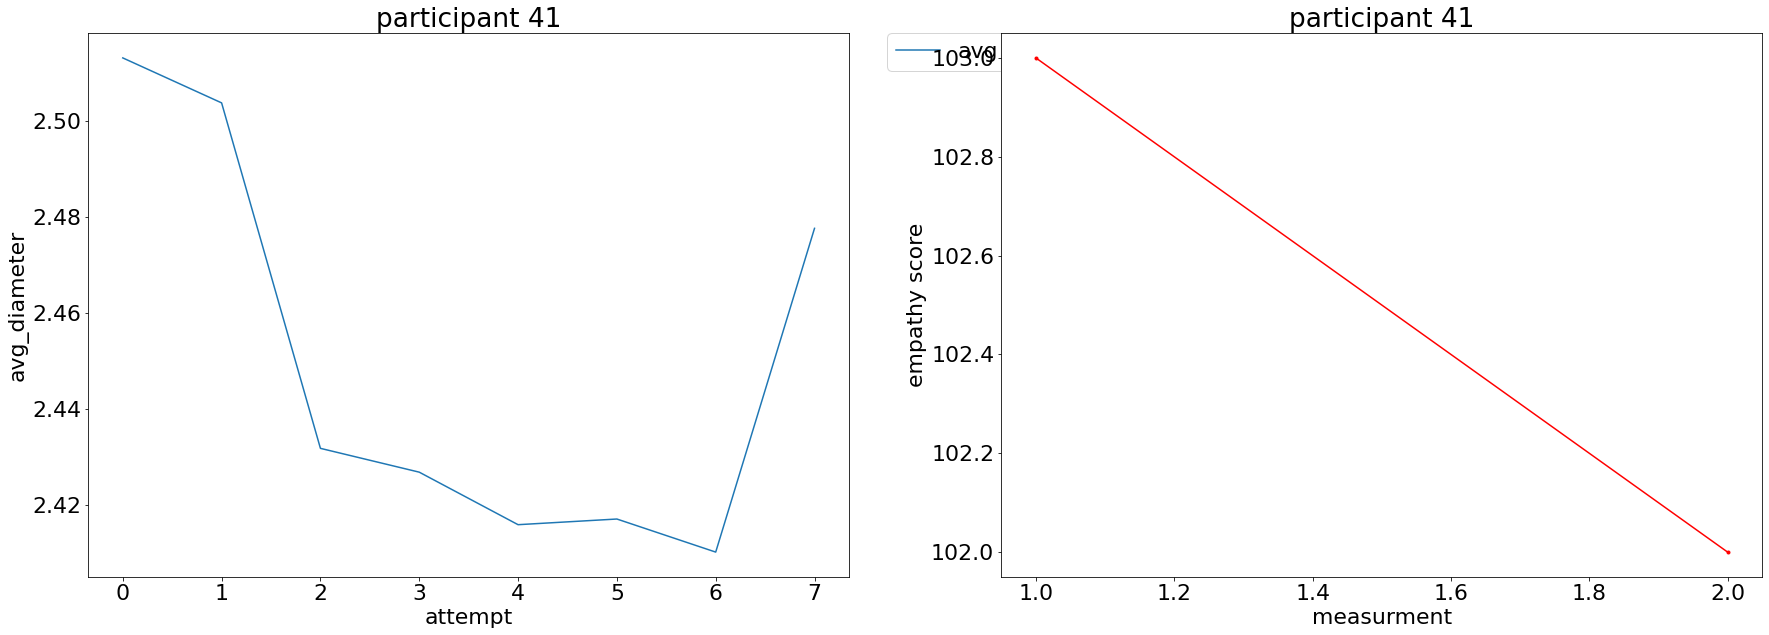

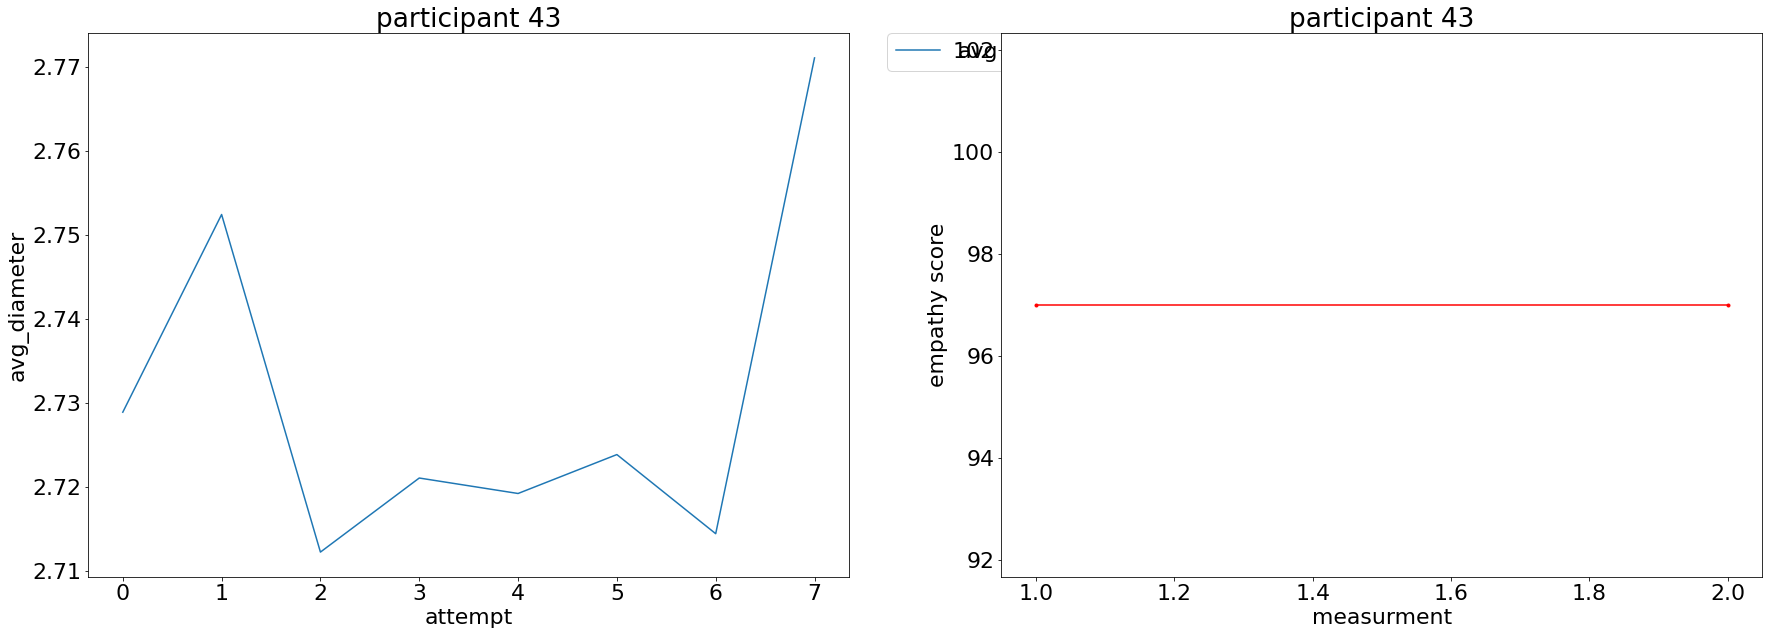

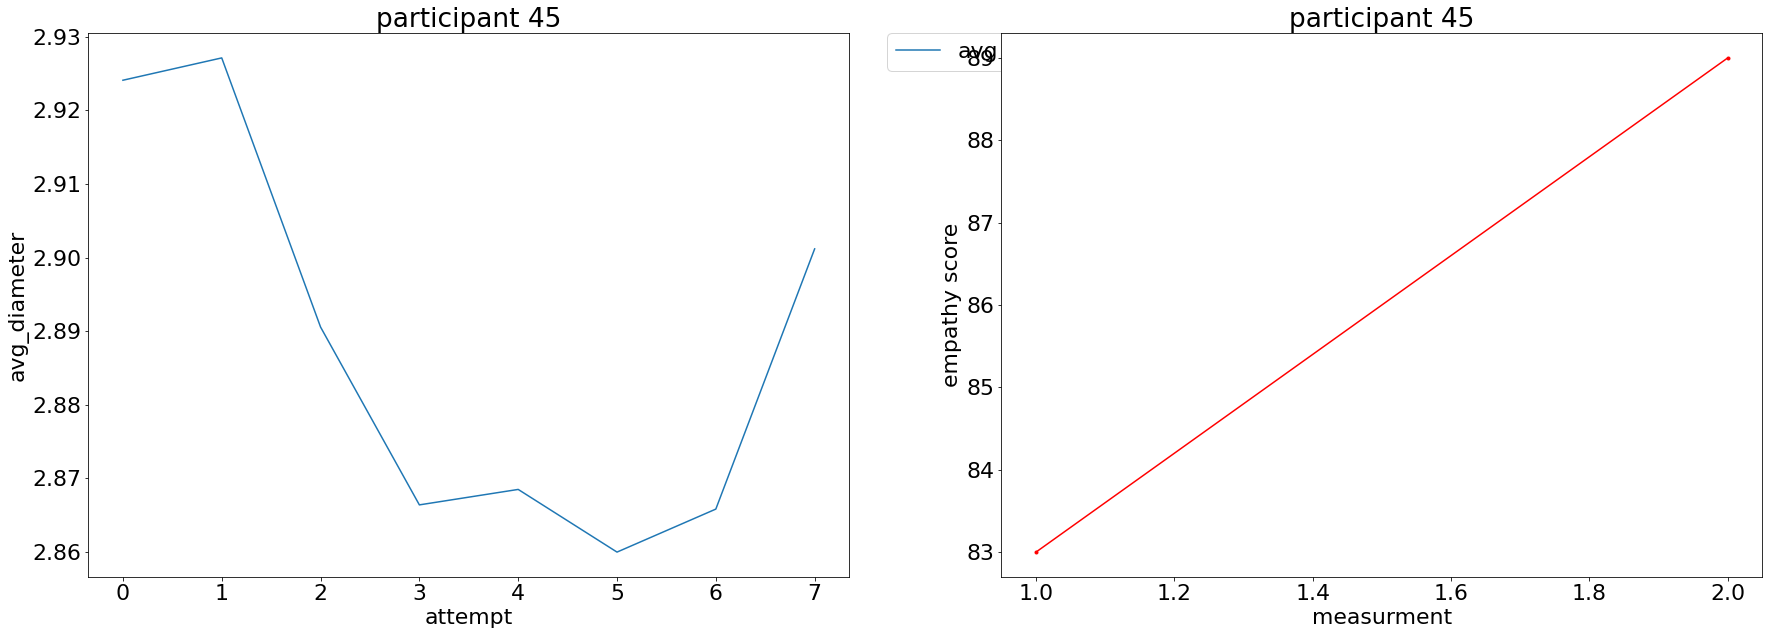

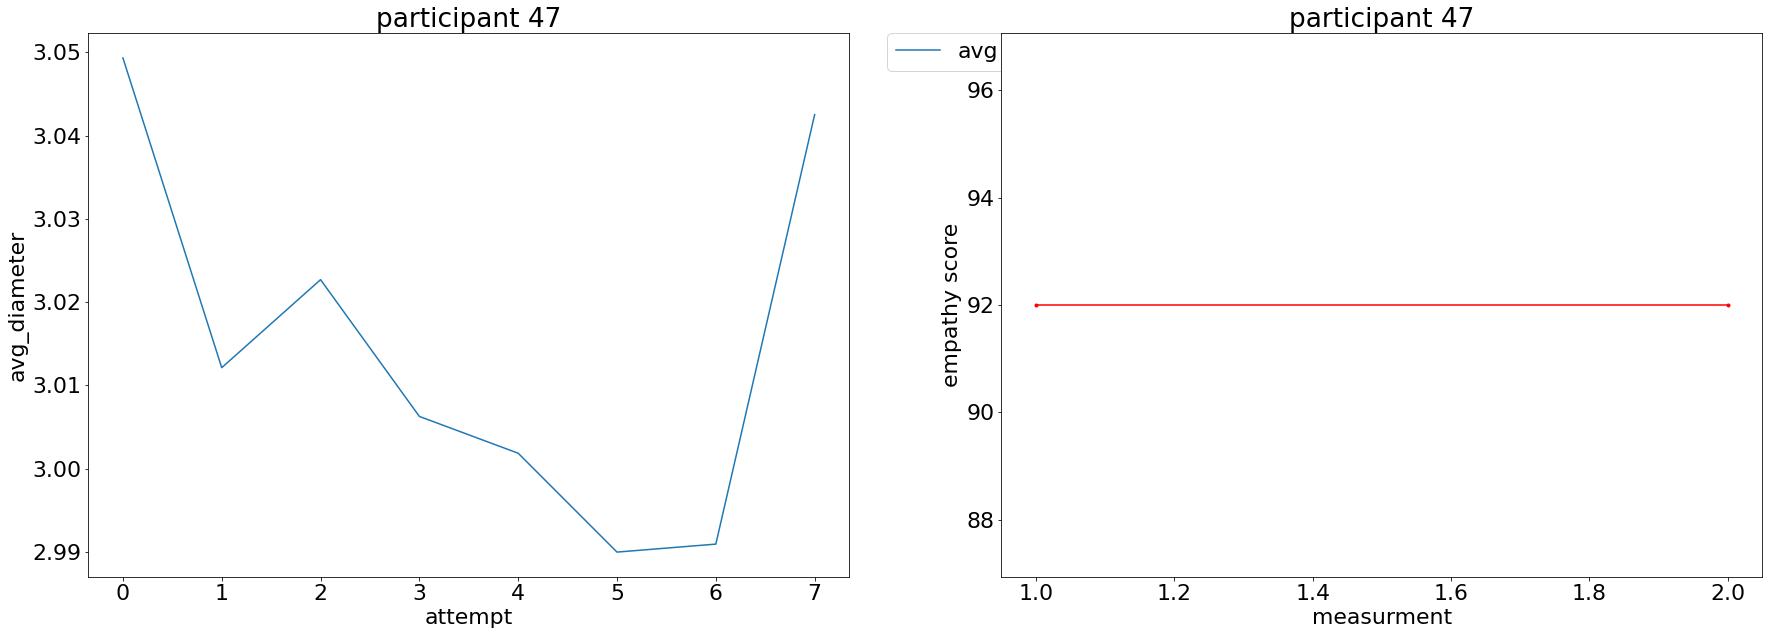

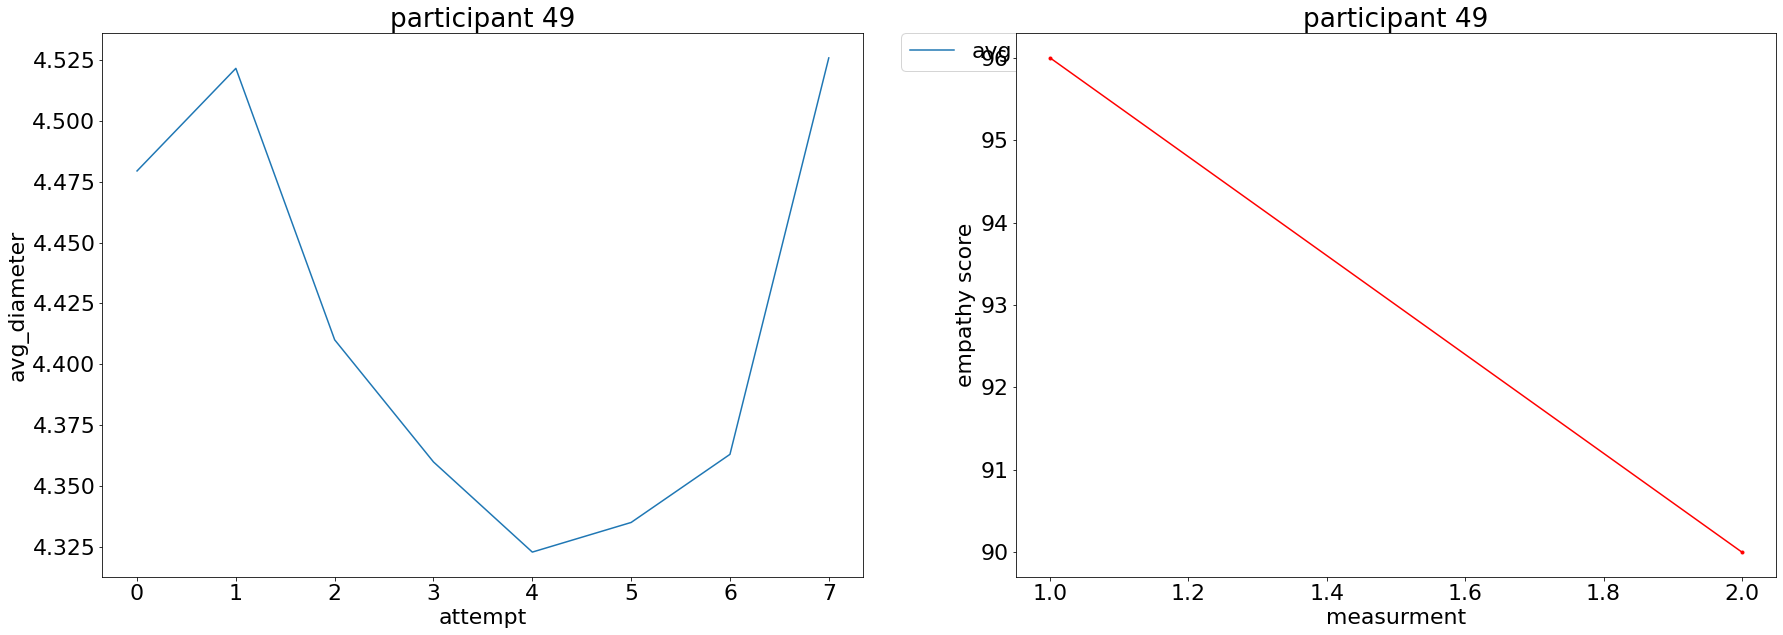

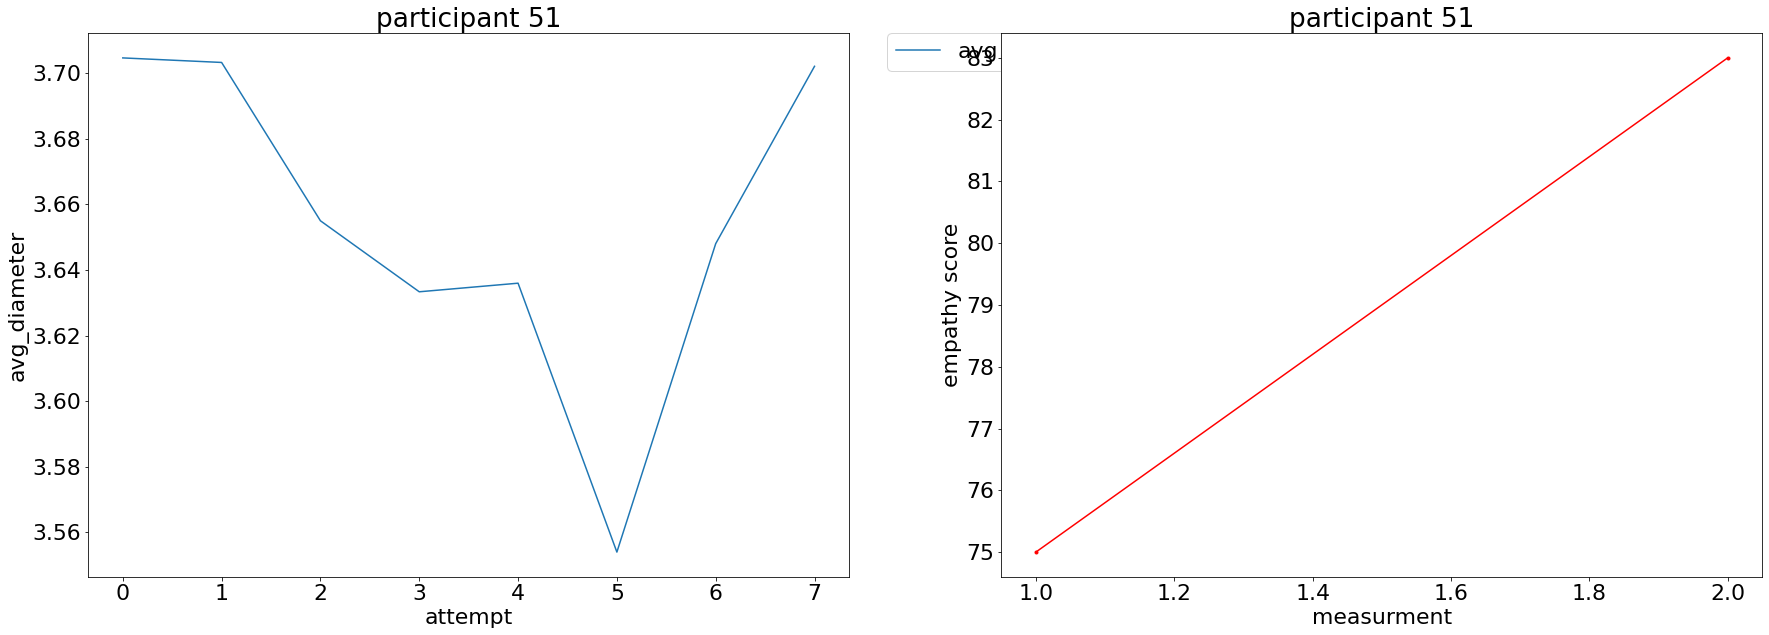

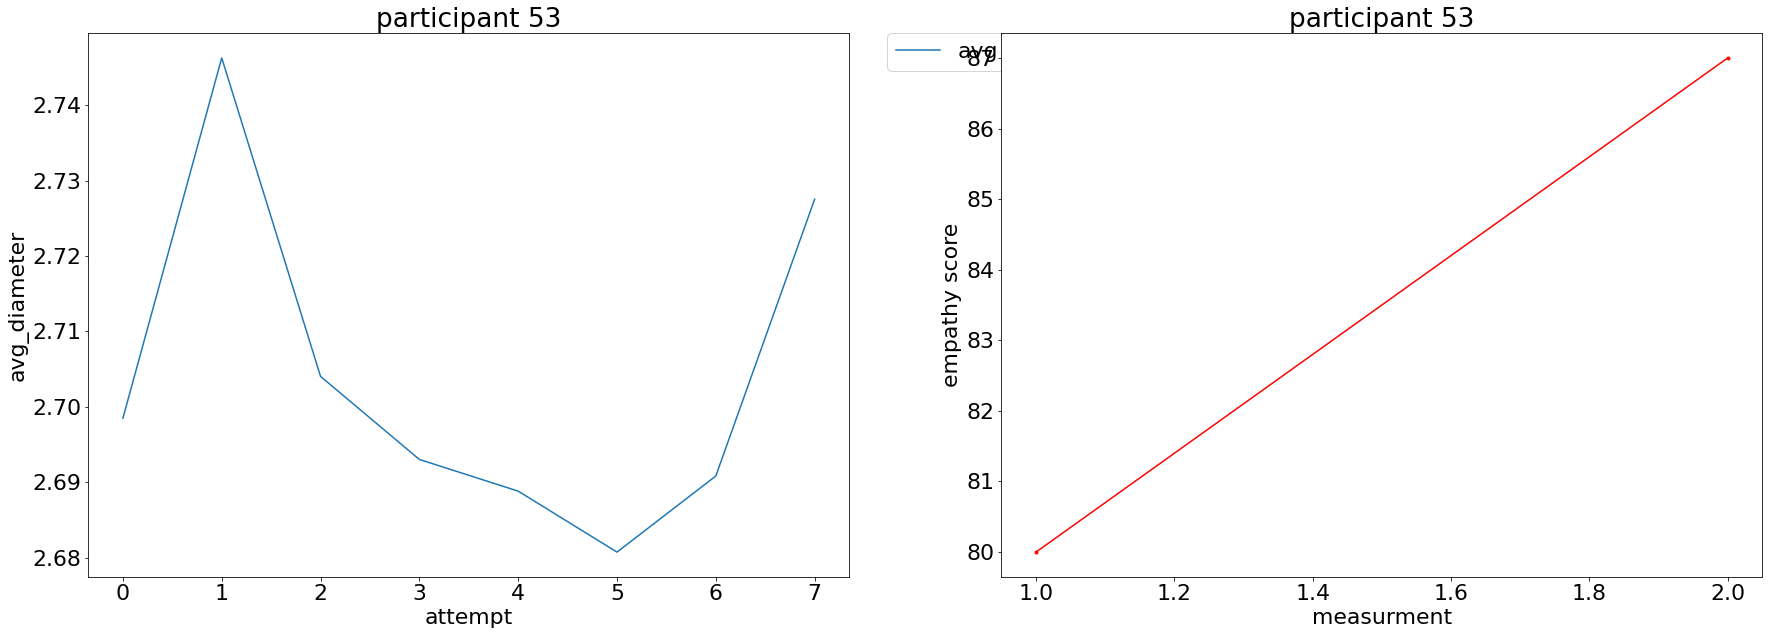

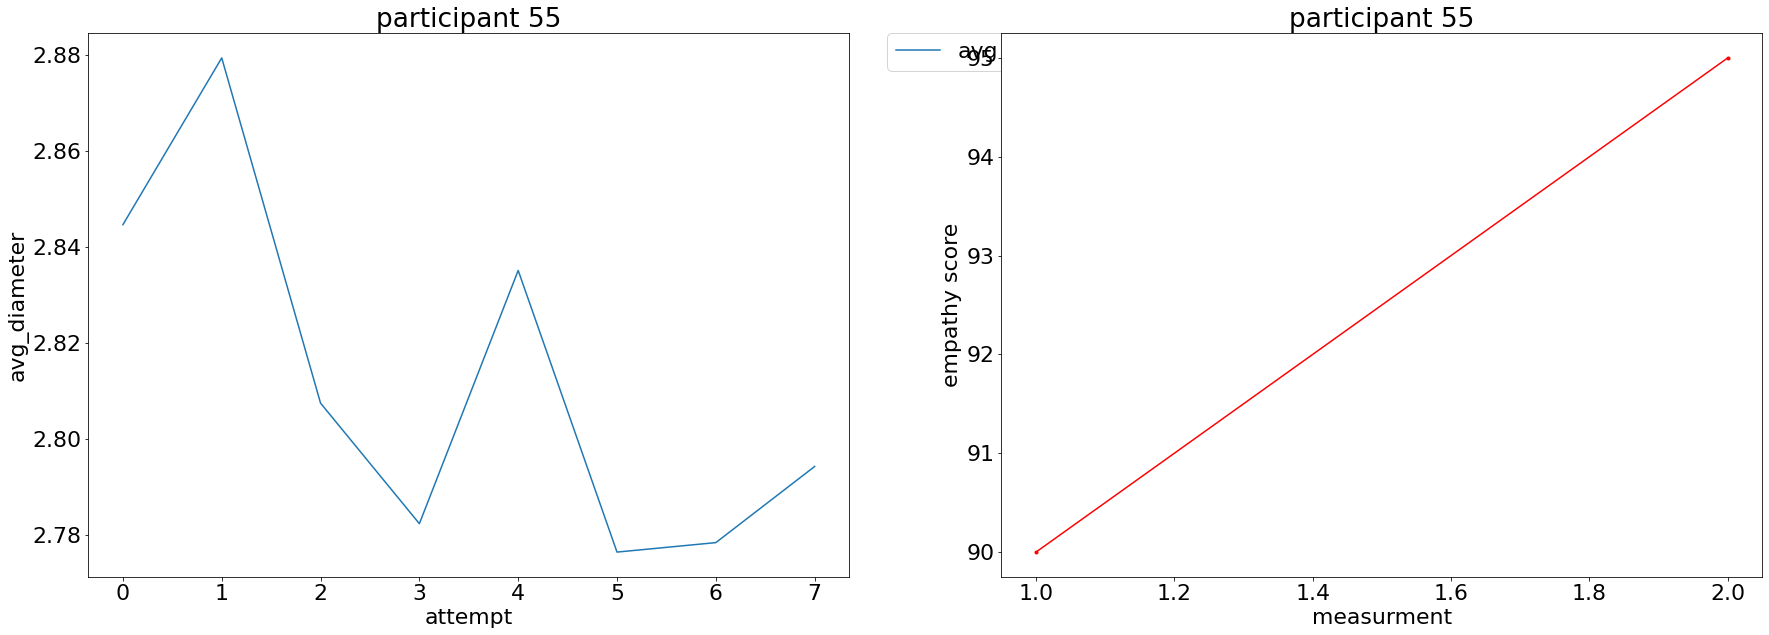

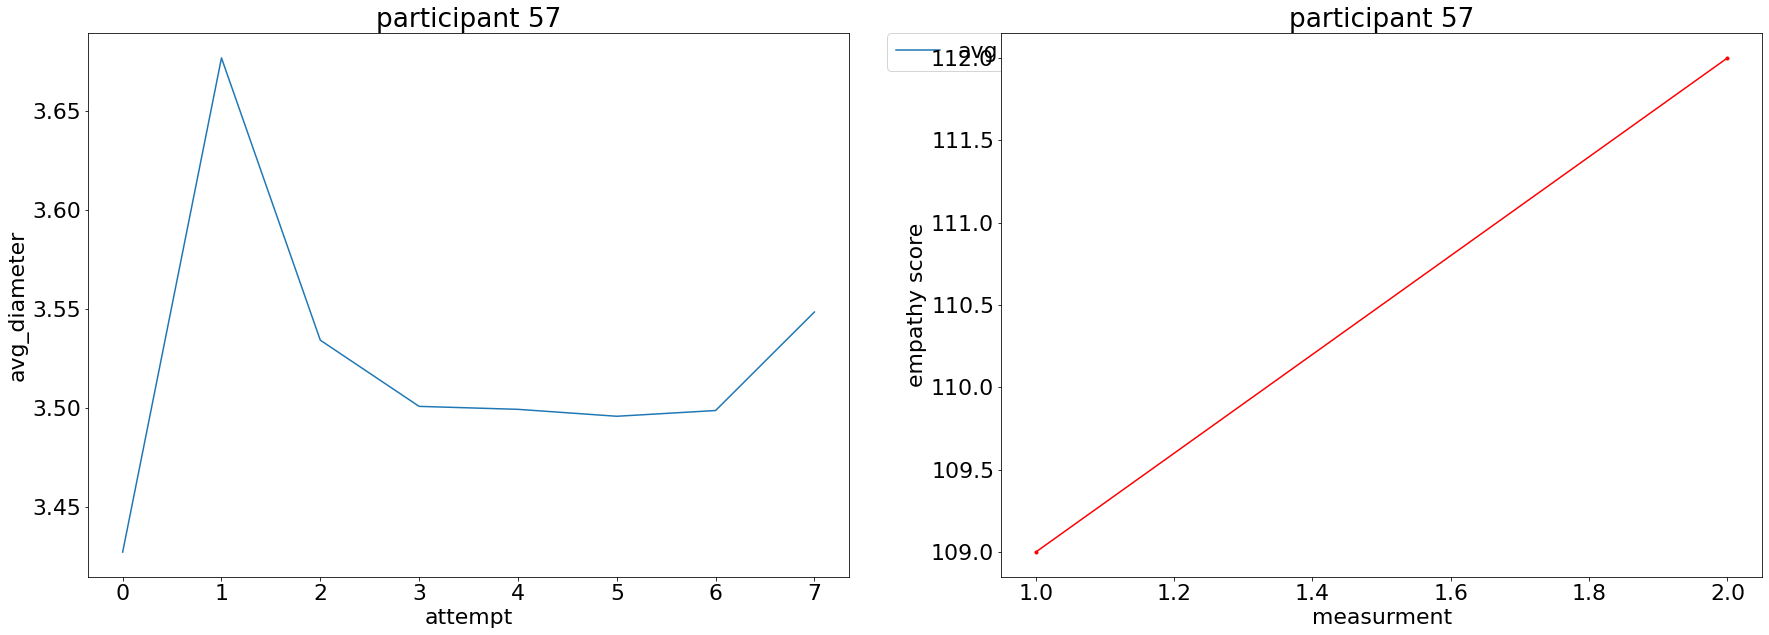

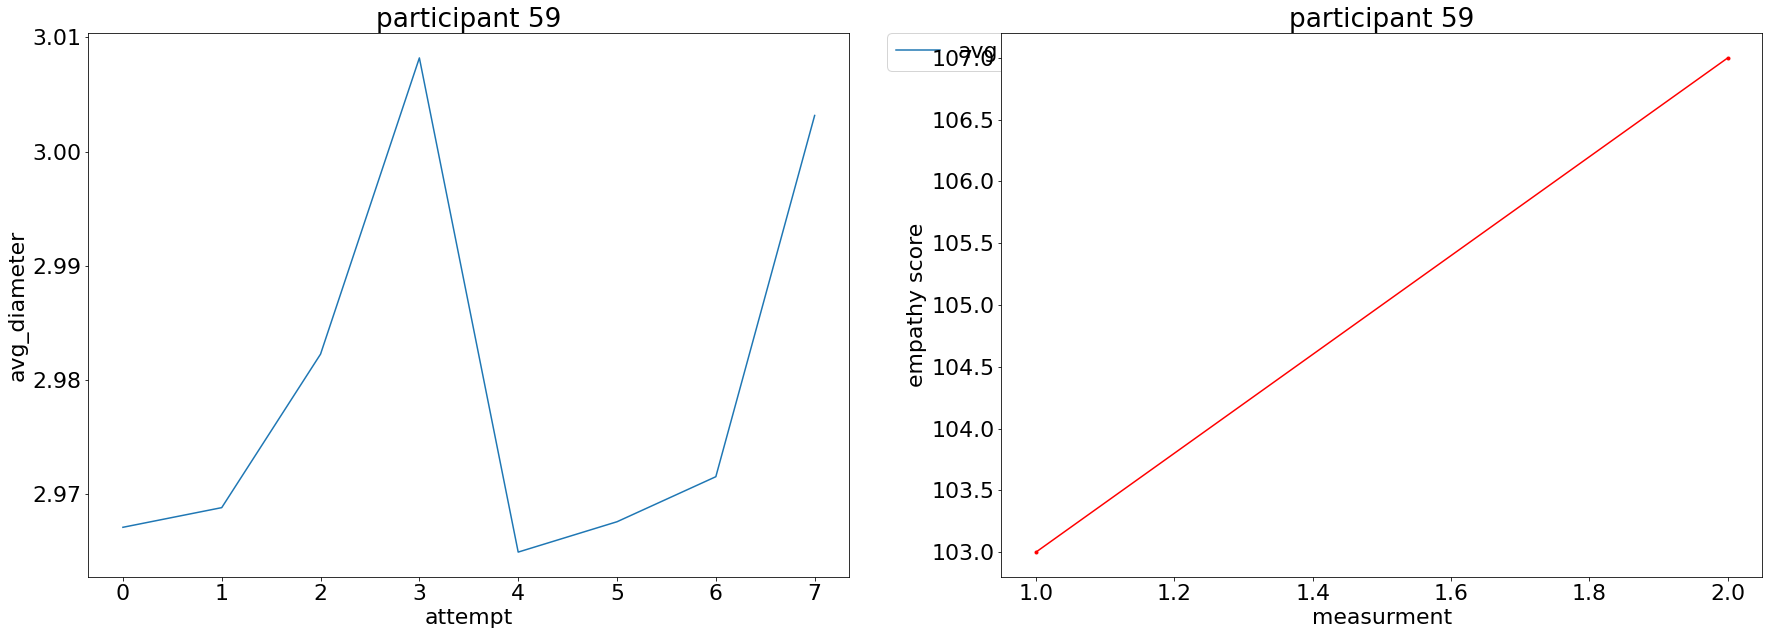

In [31]:
x = range(8)
for participant in all_participants_with_all_time_series_dict:
    attempt_pupil_avg = []
    for attempt in participant['attempts']:
        attempt_pupil_avg.append(attempt['ts_mean'])
    plt.figure(figsize=(30,10))

    plt.subplot(1, 2, 1)
    plt.plot(x, attempt_pupil_avg,'-', label='avg')
    plt.xlabel("attempt")
    plt.ylabel("avg_diameter")
    plt.title('participant ' + participant['number'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.subplot(1, 2, 2)
    plt.plot([1,2], [participant['empathy_before_std'], participant['empathy_after_std']], 'r.-')
    plt.title('participant ' + participant['number'])
    plt.xlabel('measurment')
    plt.ylabel('empathy score')
